# 引力波数据处理入门学习笔记

杨舒云 20250629

---

目录  
1. 下载与读入数据
2. 绘制 ASD 图
3. 白化
4. 带通滤波
5. 匹配滤波
6. 时频图


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ysy_plot_utils as ypu

## 1 下载与读入数据

0. 我们选定的事件是最著名的 **GW150914**。
1. 从[这里](https://github.com/gwosc-tutorial/LOSC_Event_tutorial)，下载`GW150914_4_template.hdf5` 、 `H-H1_LOSC_4_V2-1126259446-32.hdf5` 、 `L-L1_LOSC_4_V2-1126259446-32.hdf5` 和 `BBH_events_v3.json`，然后将前三个转换为CSV文件。
2. 读入数据，注意从 `BBH_events_v3.json` 读出事件发生的时刻。
3. 展示数据。

In [2]:
H1 = pd.read_csv('H1.csv')
L1 = pd.read_csv('L1.csv')

In [3]:
strain_H1 = H1['strain'].values
time_H1 = H1['GPS_time'].values
strain_L1 = L1['strain'].values
time_L1 = L1['GPS_time'].values

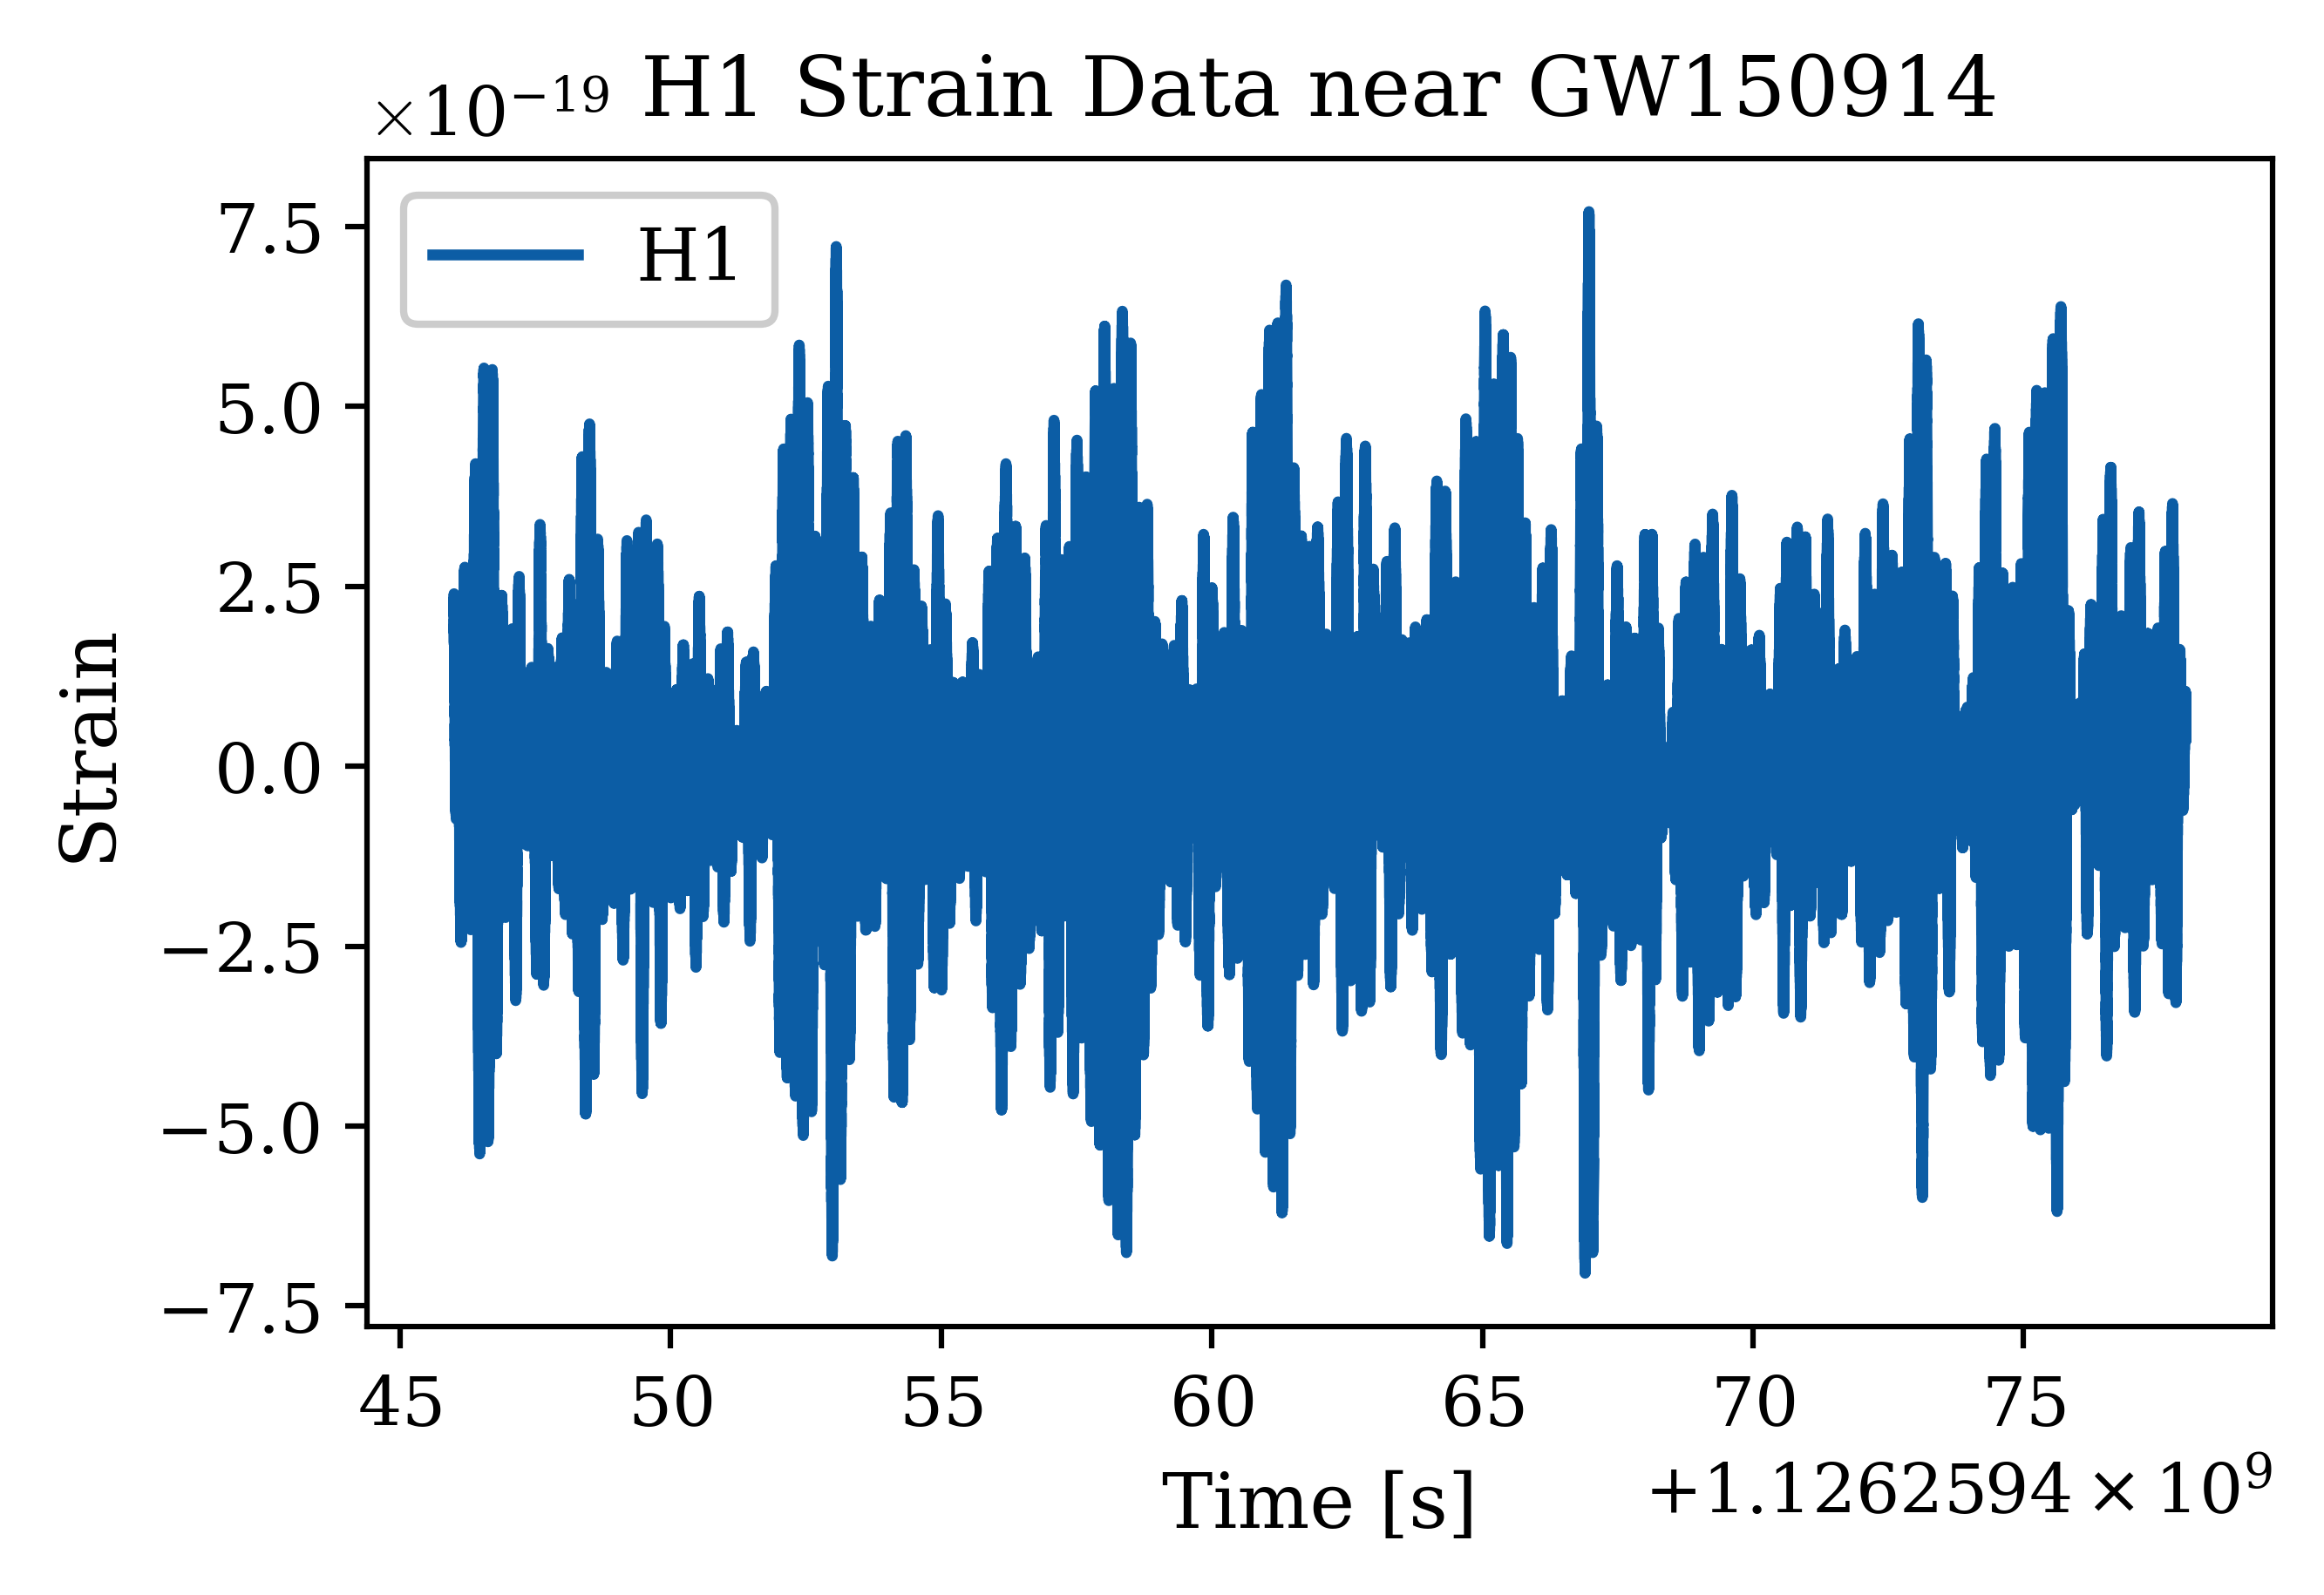

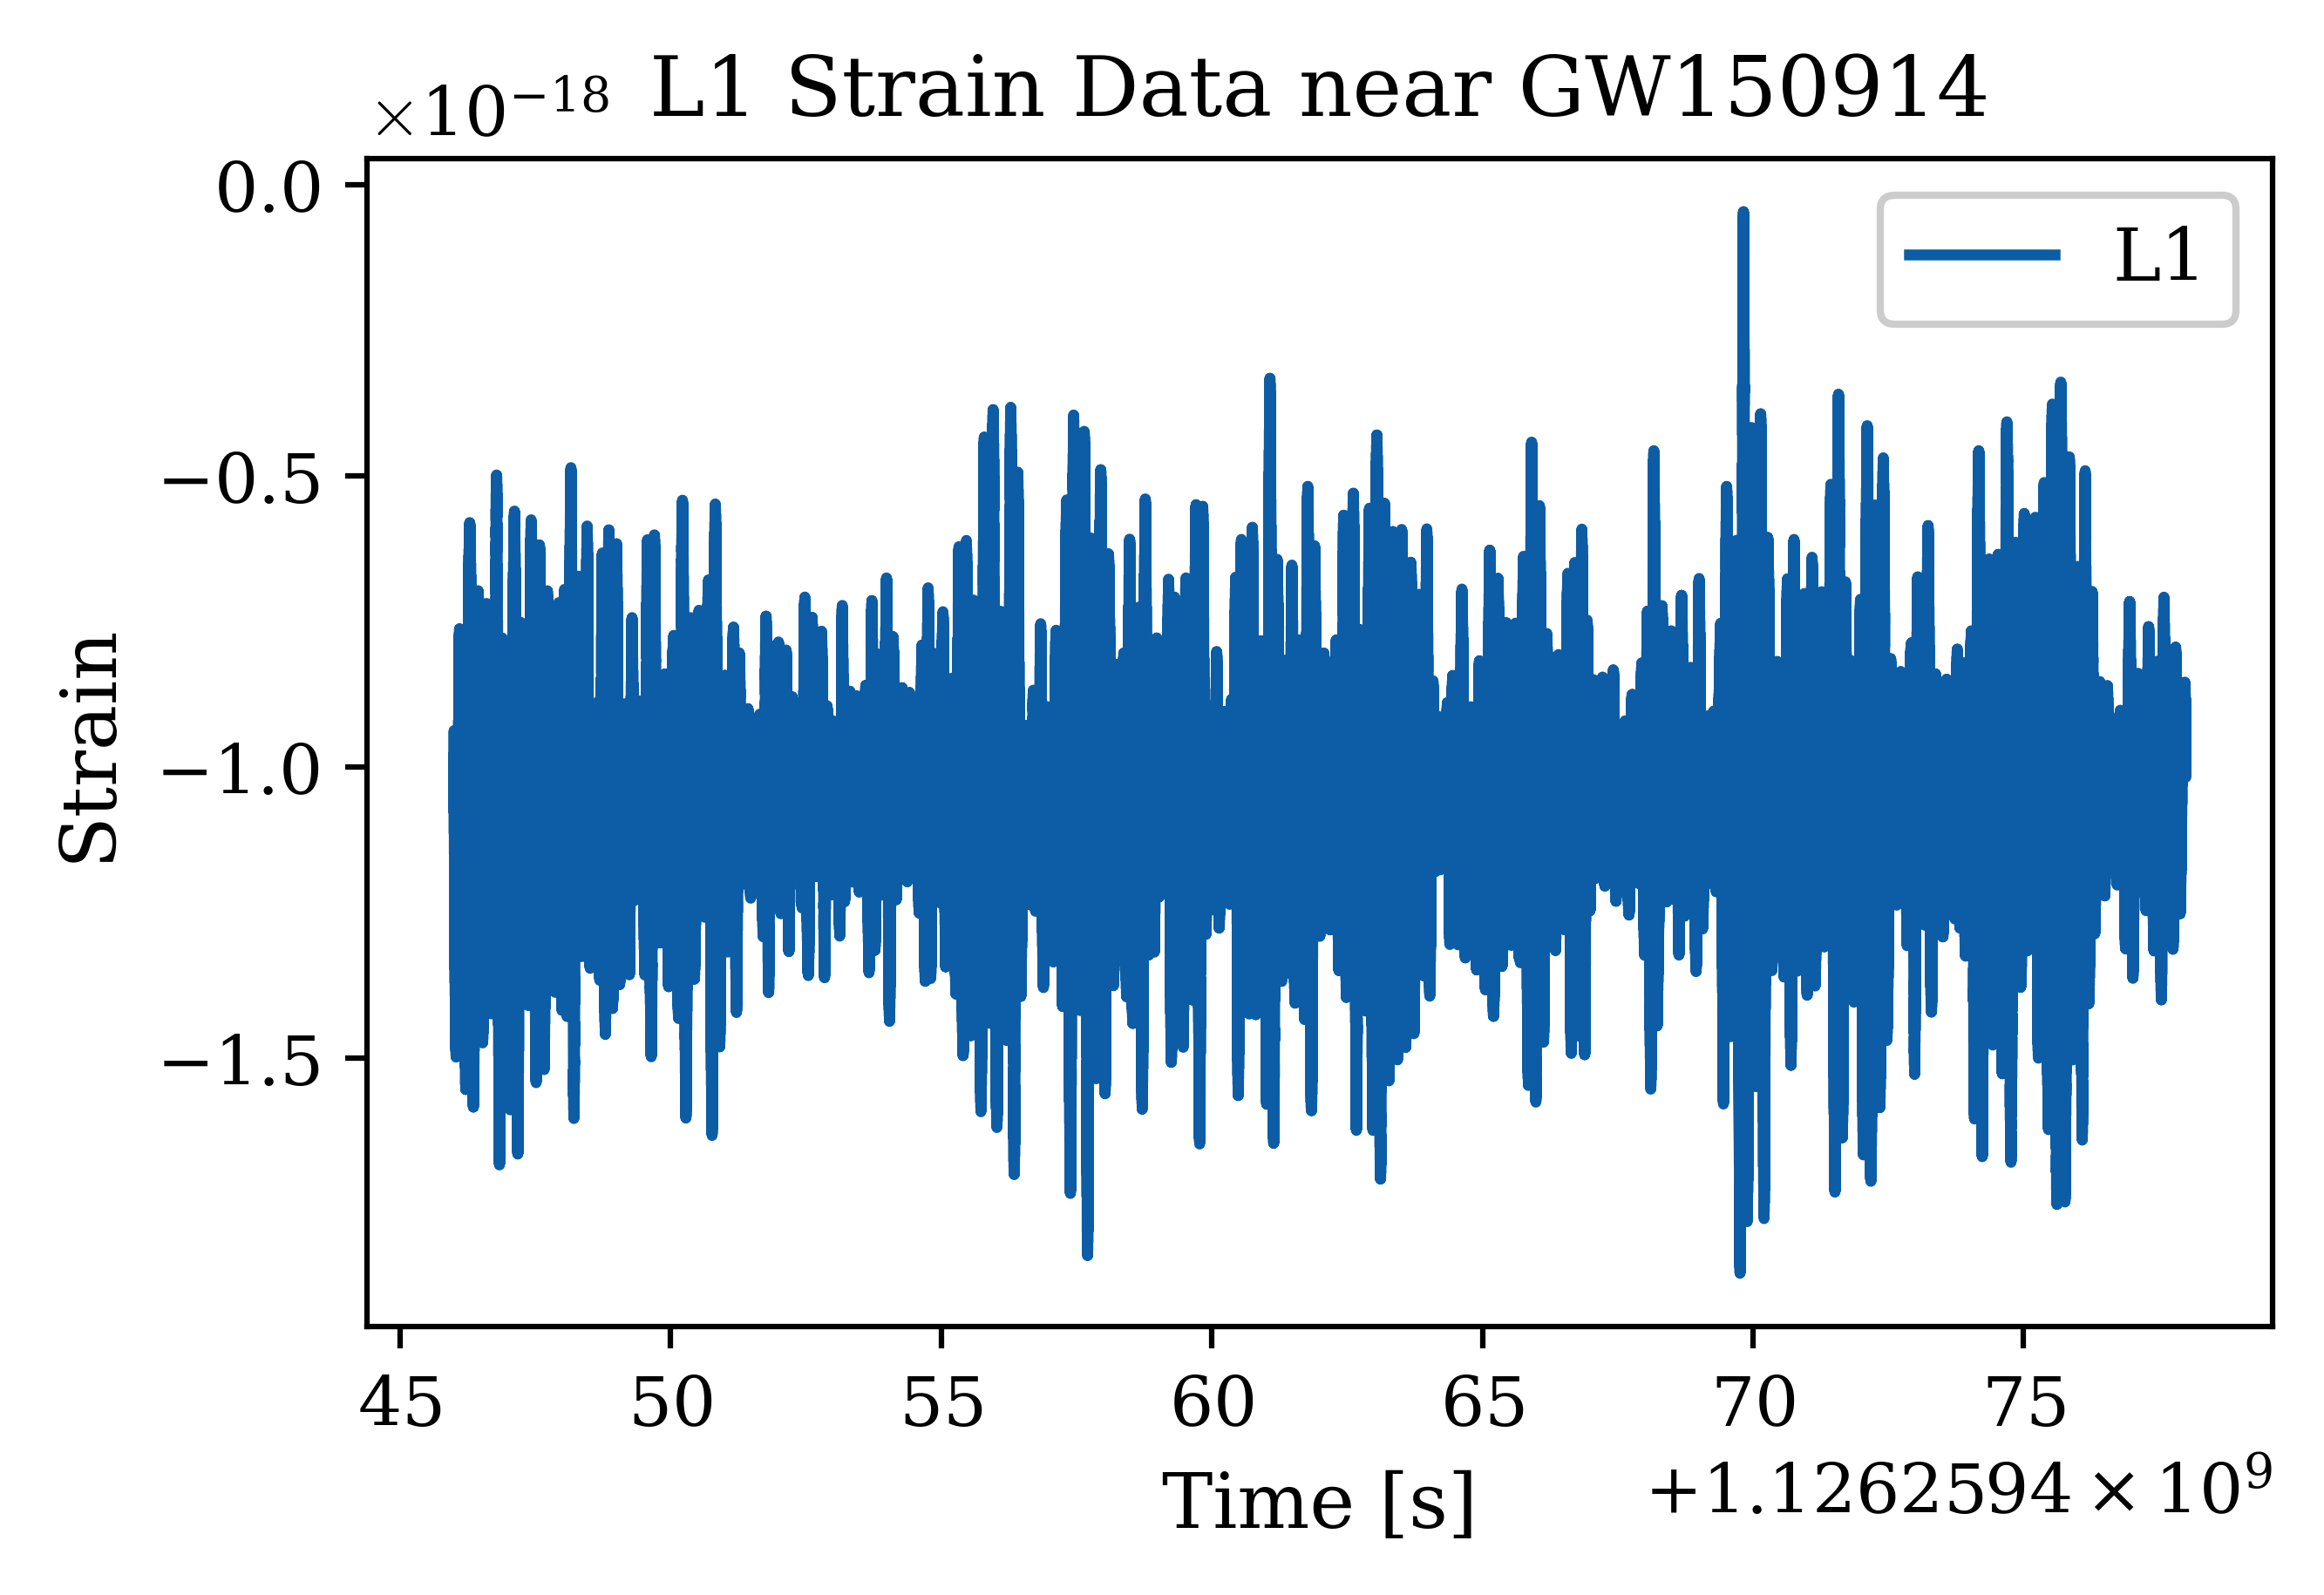

In [4]:
with ypu.temp_style(["ysy_academic", "science_color"]):
    ypu.plot(
        time_H1,strain_H1, 'H1', 
        'H1 Strain Data near GW150914', 'Time [s]', 'Strain'
    )
    ypu.plot(
        time_L1,strain_L1, 'L1', 
        'L1 Strain Data near GW150914', 'Time [s]', 'Strain'
    )

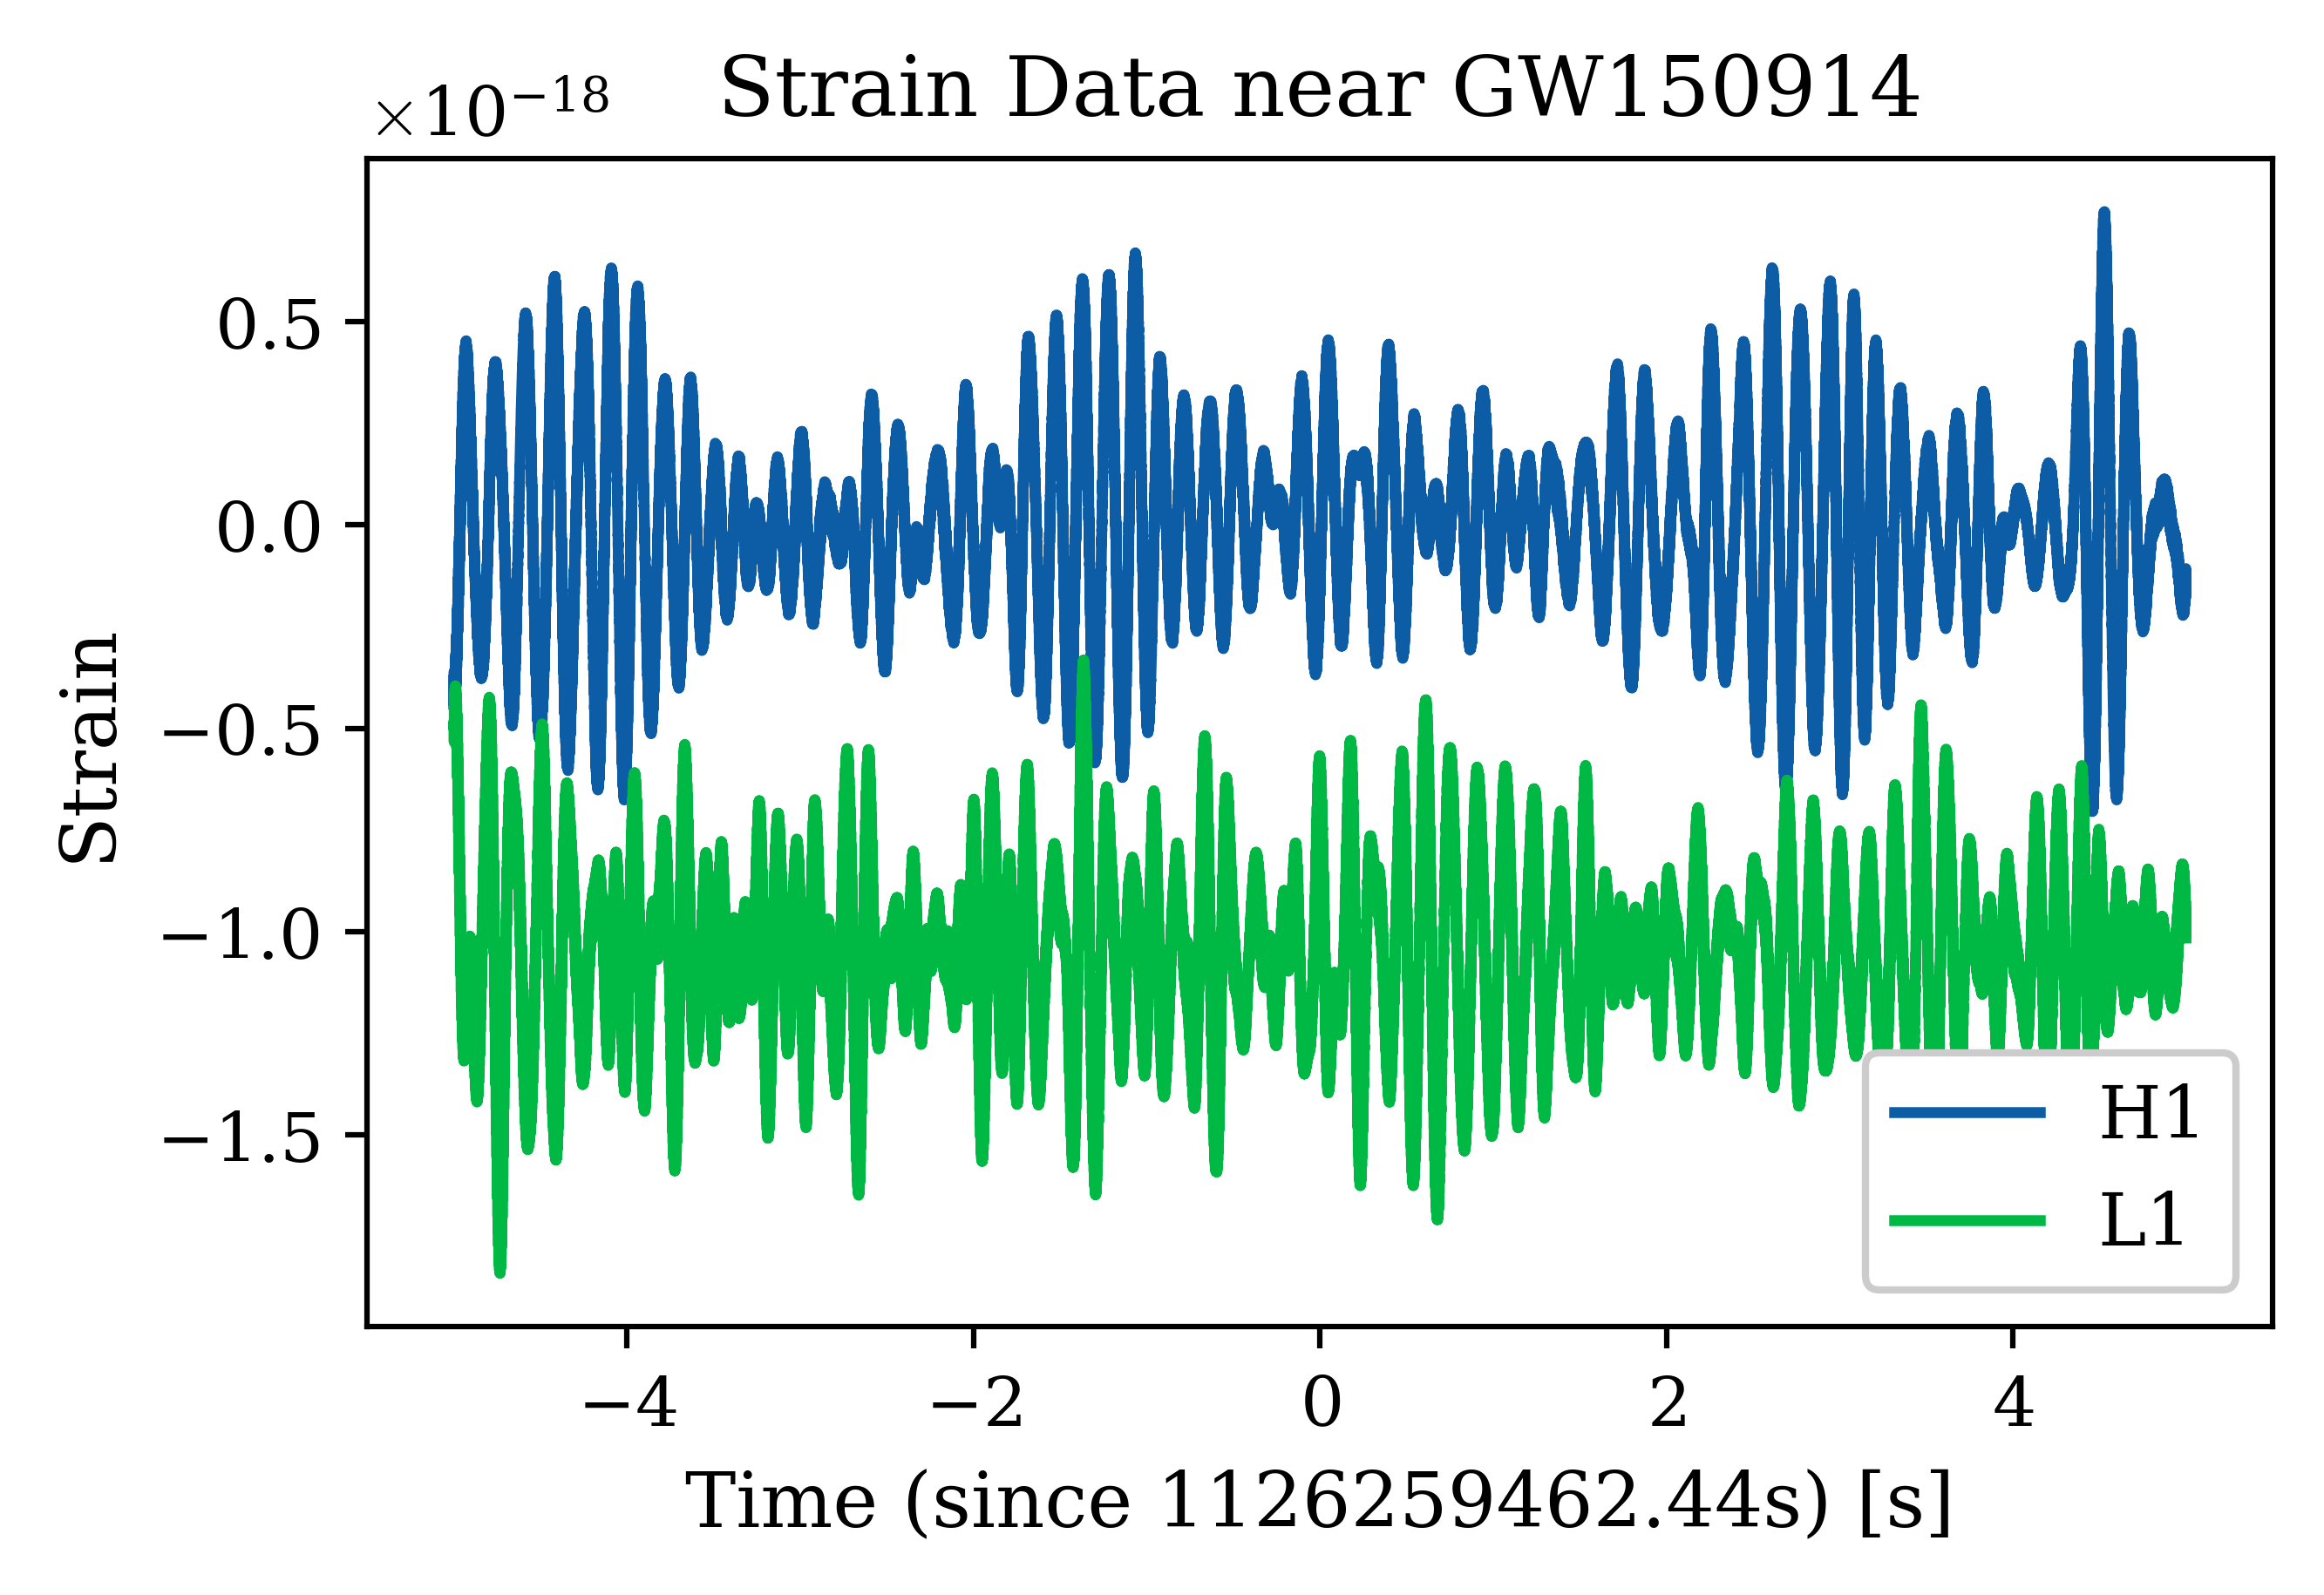

In [5]:
time = time_H1
dt = time[1] - time[0]
t_event = 1126259462.44
delta_t = 5
indxt = np.where((time >= t_event-delta_t) & (time < t_event+delta_t))

with ypu.temp_style(["ysy_academic", "science_color"]):
    ypu.plot(
        time[indxt]-t_event, (strain_H1[indxt], strain_L1[indxt]), ('H1', 'L1'), 
        'Strain Data near GW150914', 'Time (since 1126259462.44s) [s]', 'Strain'
    )

## 2 绘制 ASD 图

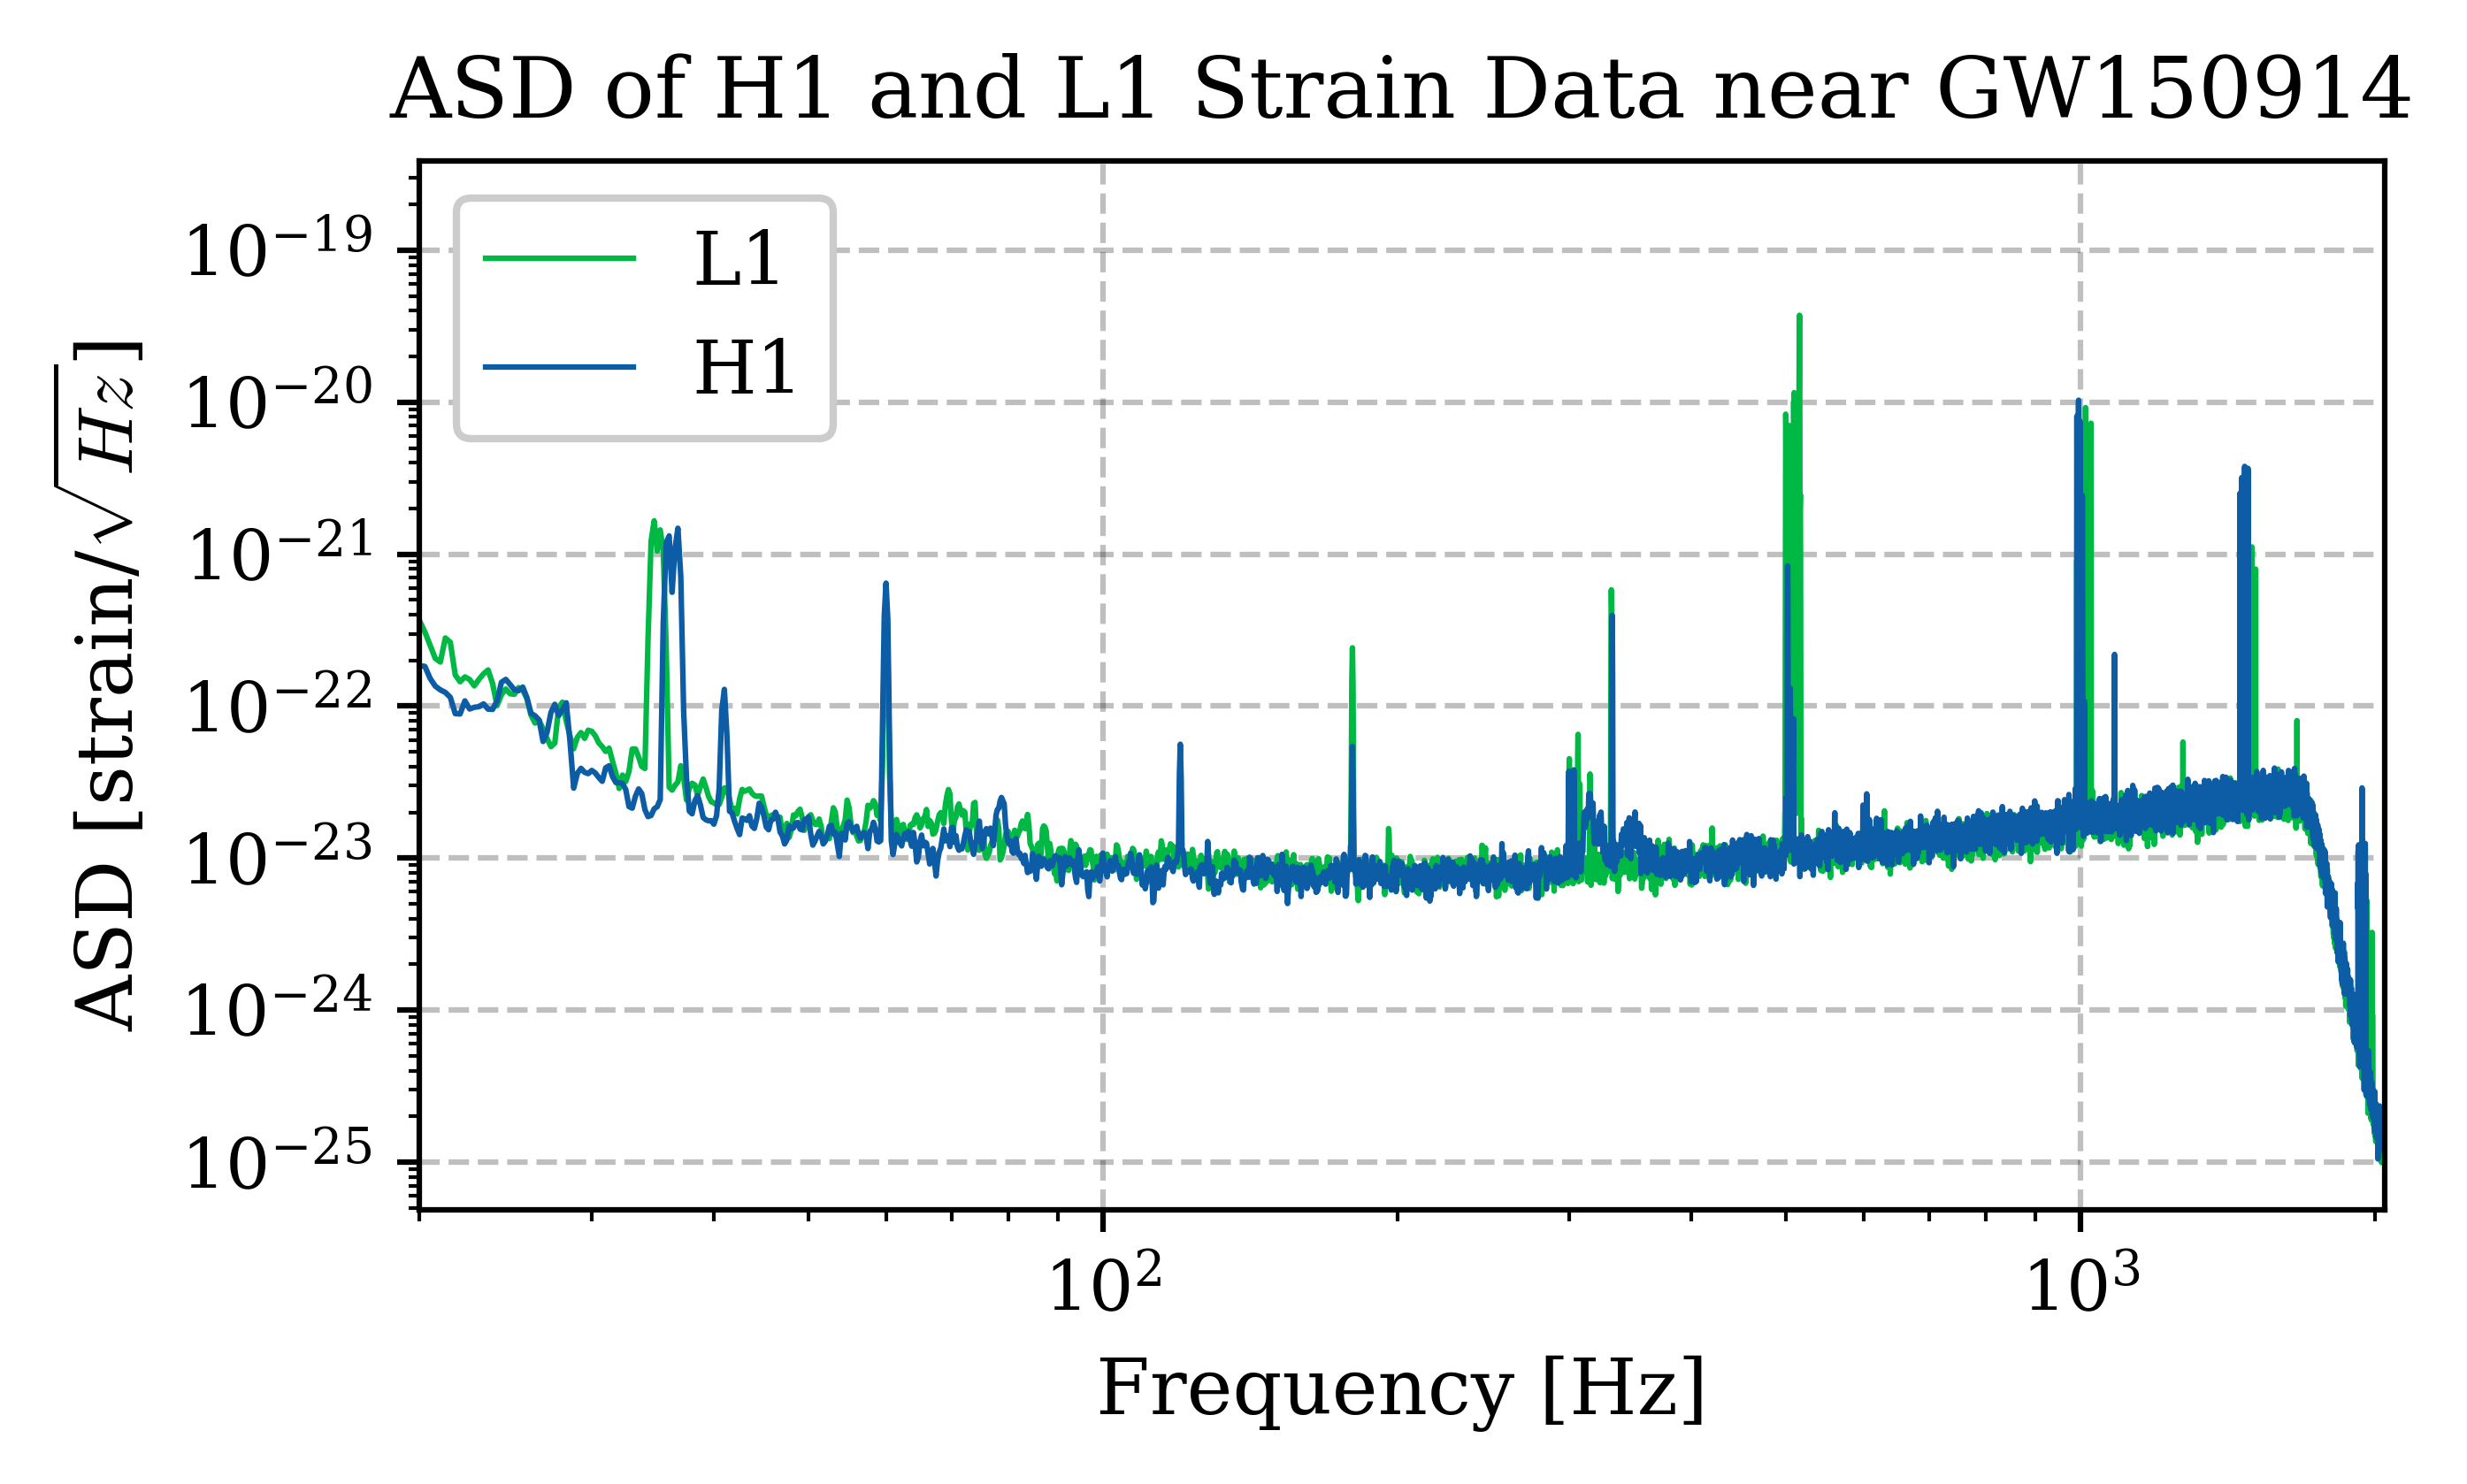

In [6]:
from scipy.signal import welch # 导入 Welch 方法计算 PSD

fs = 4096 # 采样频率
duration = 4 # 数据时长，单位秒
num_samples = int(fs * duration)

# 计算 H1 的 PSD 和 ASD
# nperseg 参数指定了用于计算每个段的 FFT 的数据点数。
# 较大的 nperseg 会得到更好的频率分辨率，但时间分辨率会降低。
# 这里我们选择 fs * 4 作为段长，即 4 秒的数据。
# noverlap 默认是 nperseg 的 50%，这里显式写出。
f_H1, psd_H1 = welch(strain_H1, fs=fs, nperseg=num_samples, noverlap=int(fs * 2), window='blackman')
asd_H1 = np.sqrt(psd_H1) # ASD 是 PSD 的平方根

# 计算 L1 的 PSD 和 ASD
f_L1, psd_L1 = welch(strain_L1, fs=fs, nperseg=num_samples, noverlap=int(fs * 2), window='blackman')
asd_L1 = np.sqrt(psd_L1) # ASD 是 PSD 的平方根

# 绘图
with ypu.temp_style(["ysy_academic", "science_color"]):
    plt.figure()
    plt.loglog(f_L1, asd_L1, label='L1', linewidth=0.75, color='C1')
    plt.loglog(f_H1, asd_H1, label='H1', linewidth=0.75, color='C0')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('ASD [strain/$\sqrt{Hz}$]')
    plt.title('ASD of H1 and L1 Strain Data near GW150914')
    plt.legend()
    plt.grid(alpha=0.25)
    plt.xlim(20, fs / 2)
    plt.tight_layout()
    plt.show()

## 3 白化

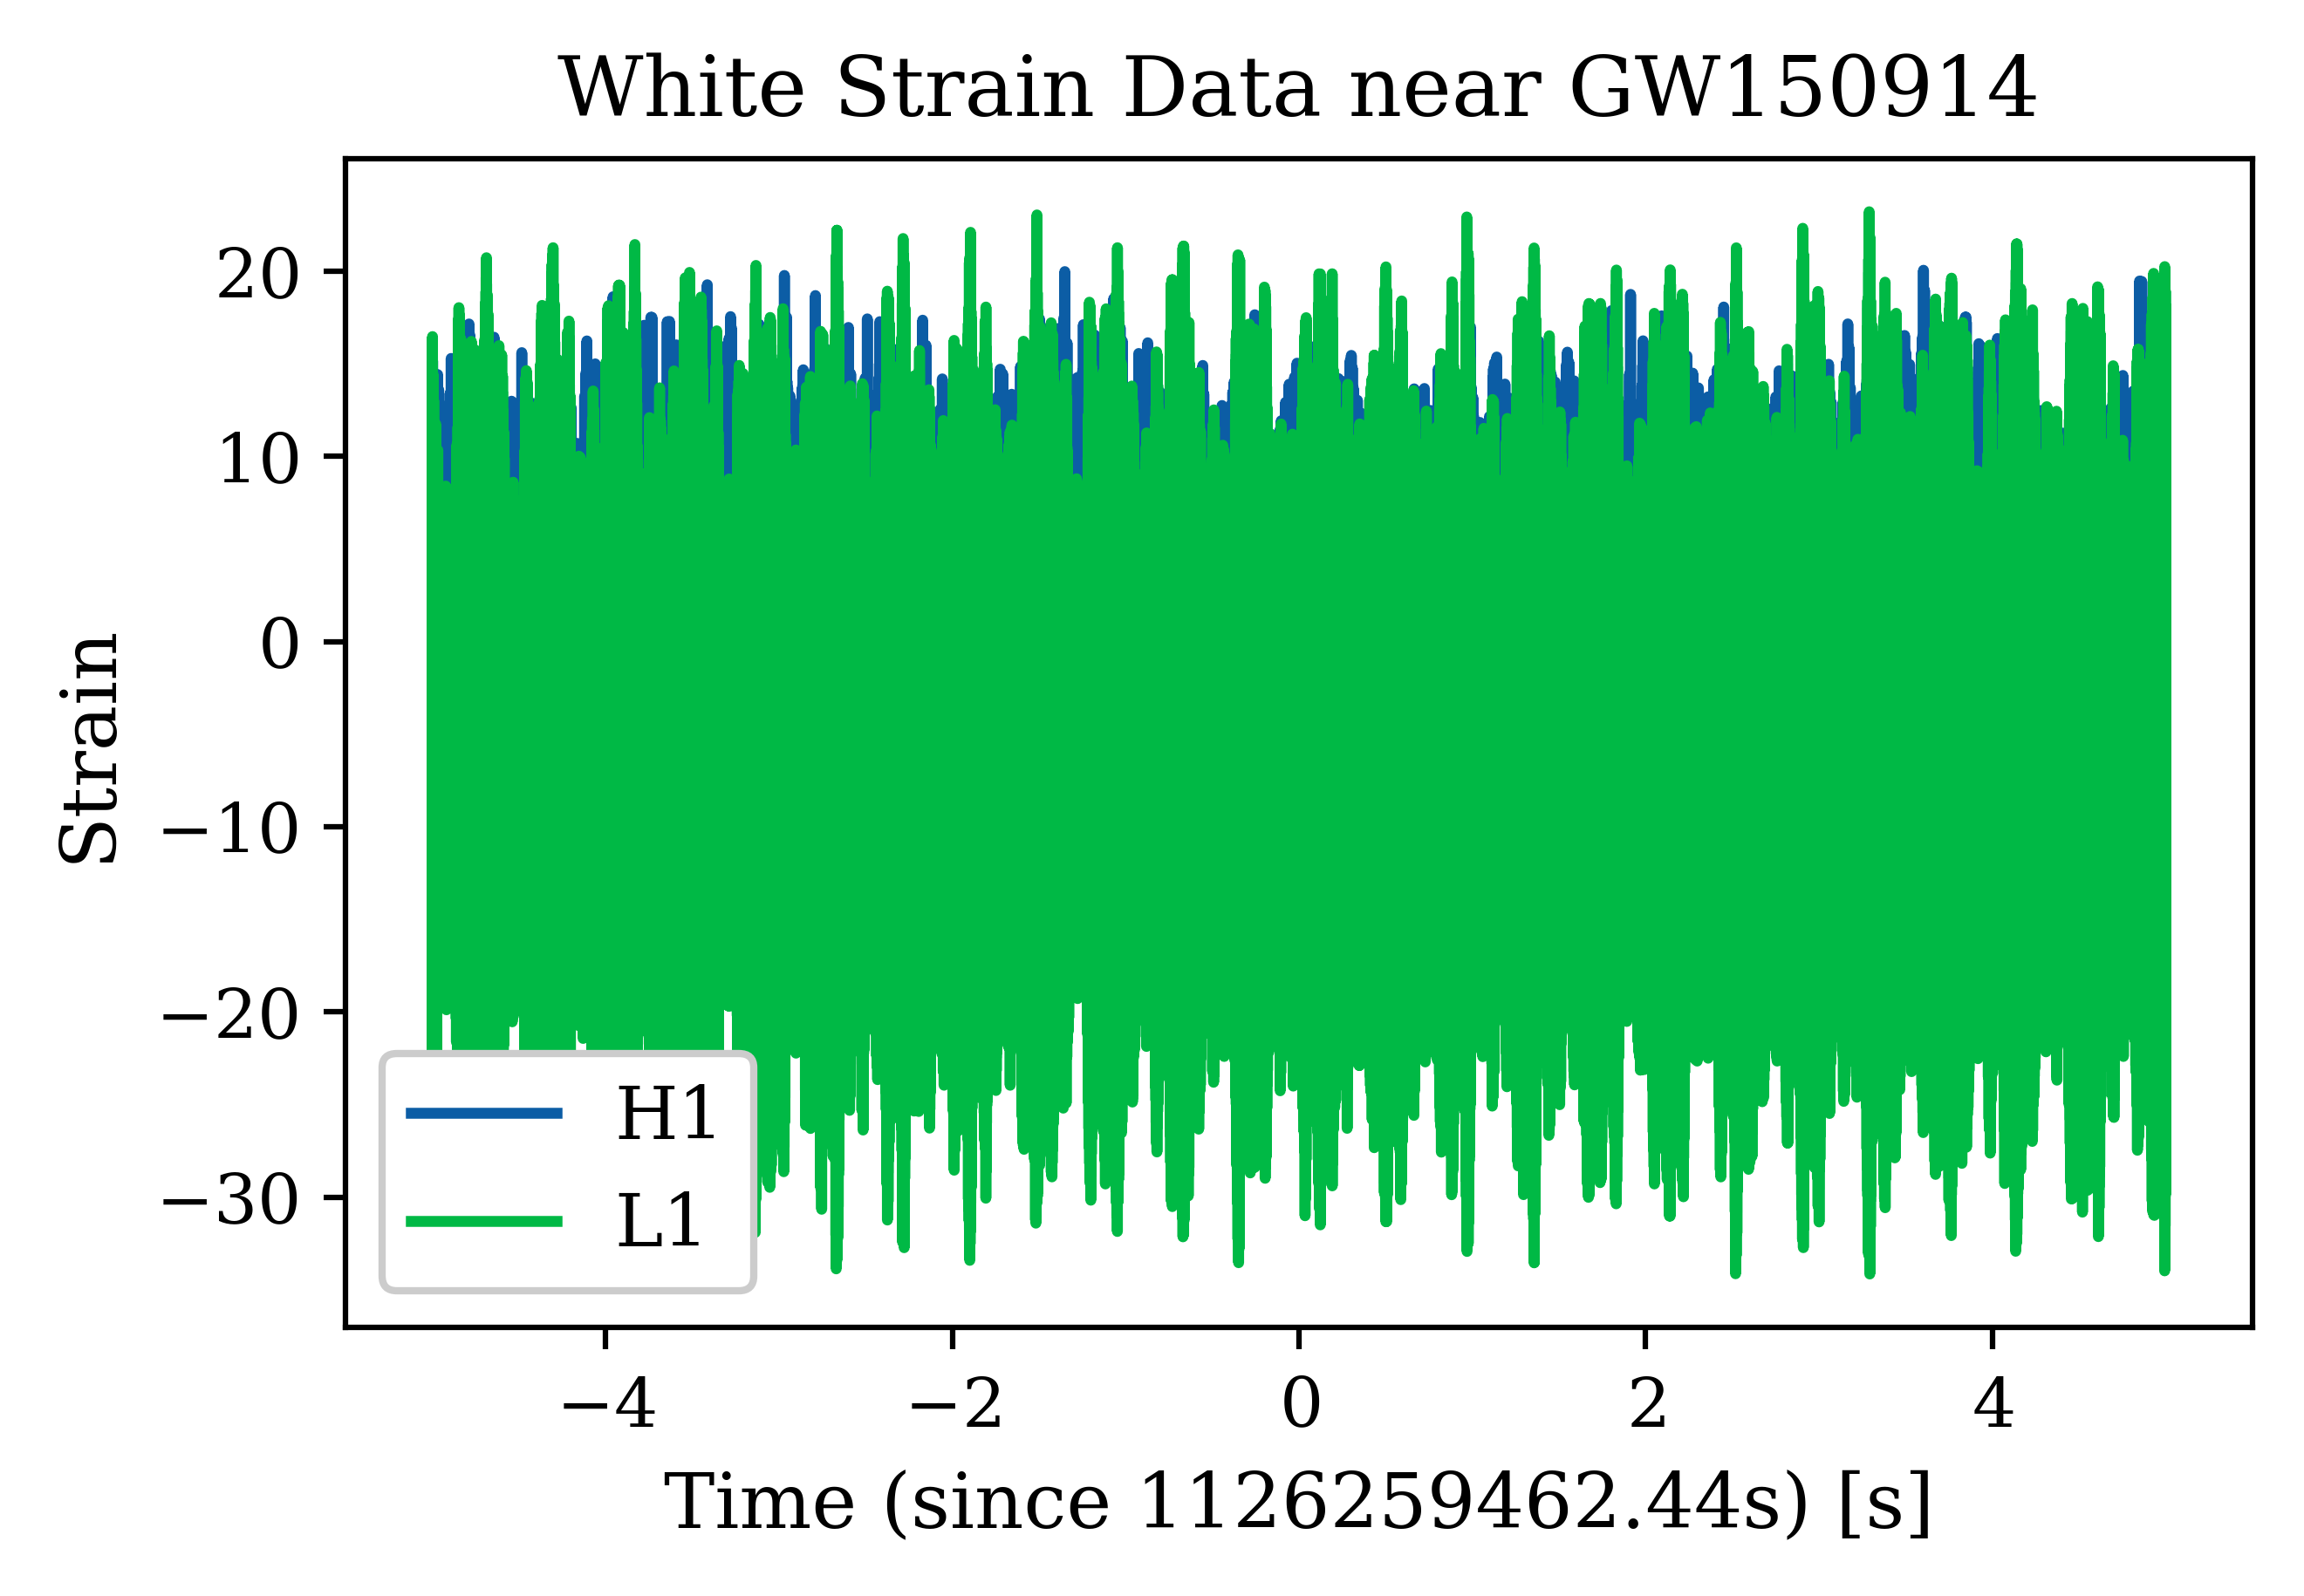

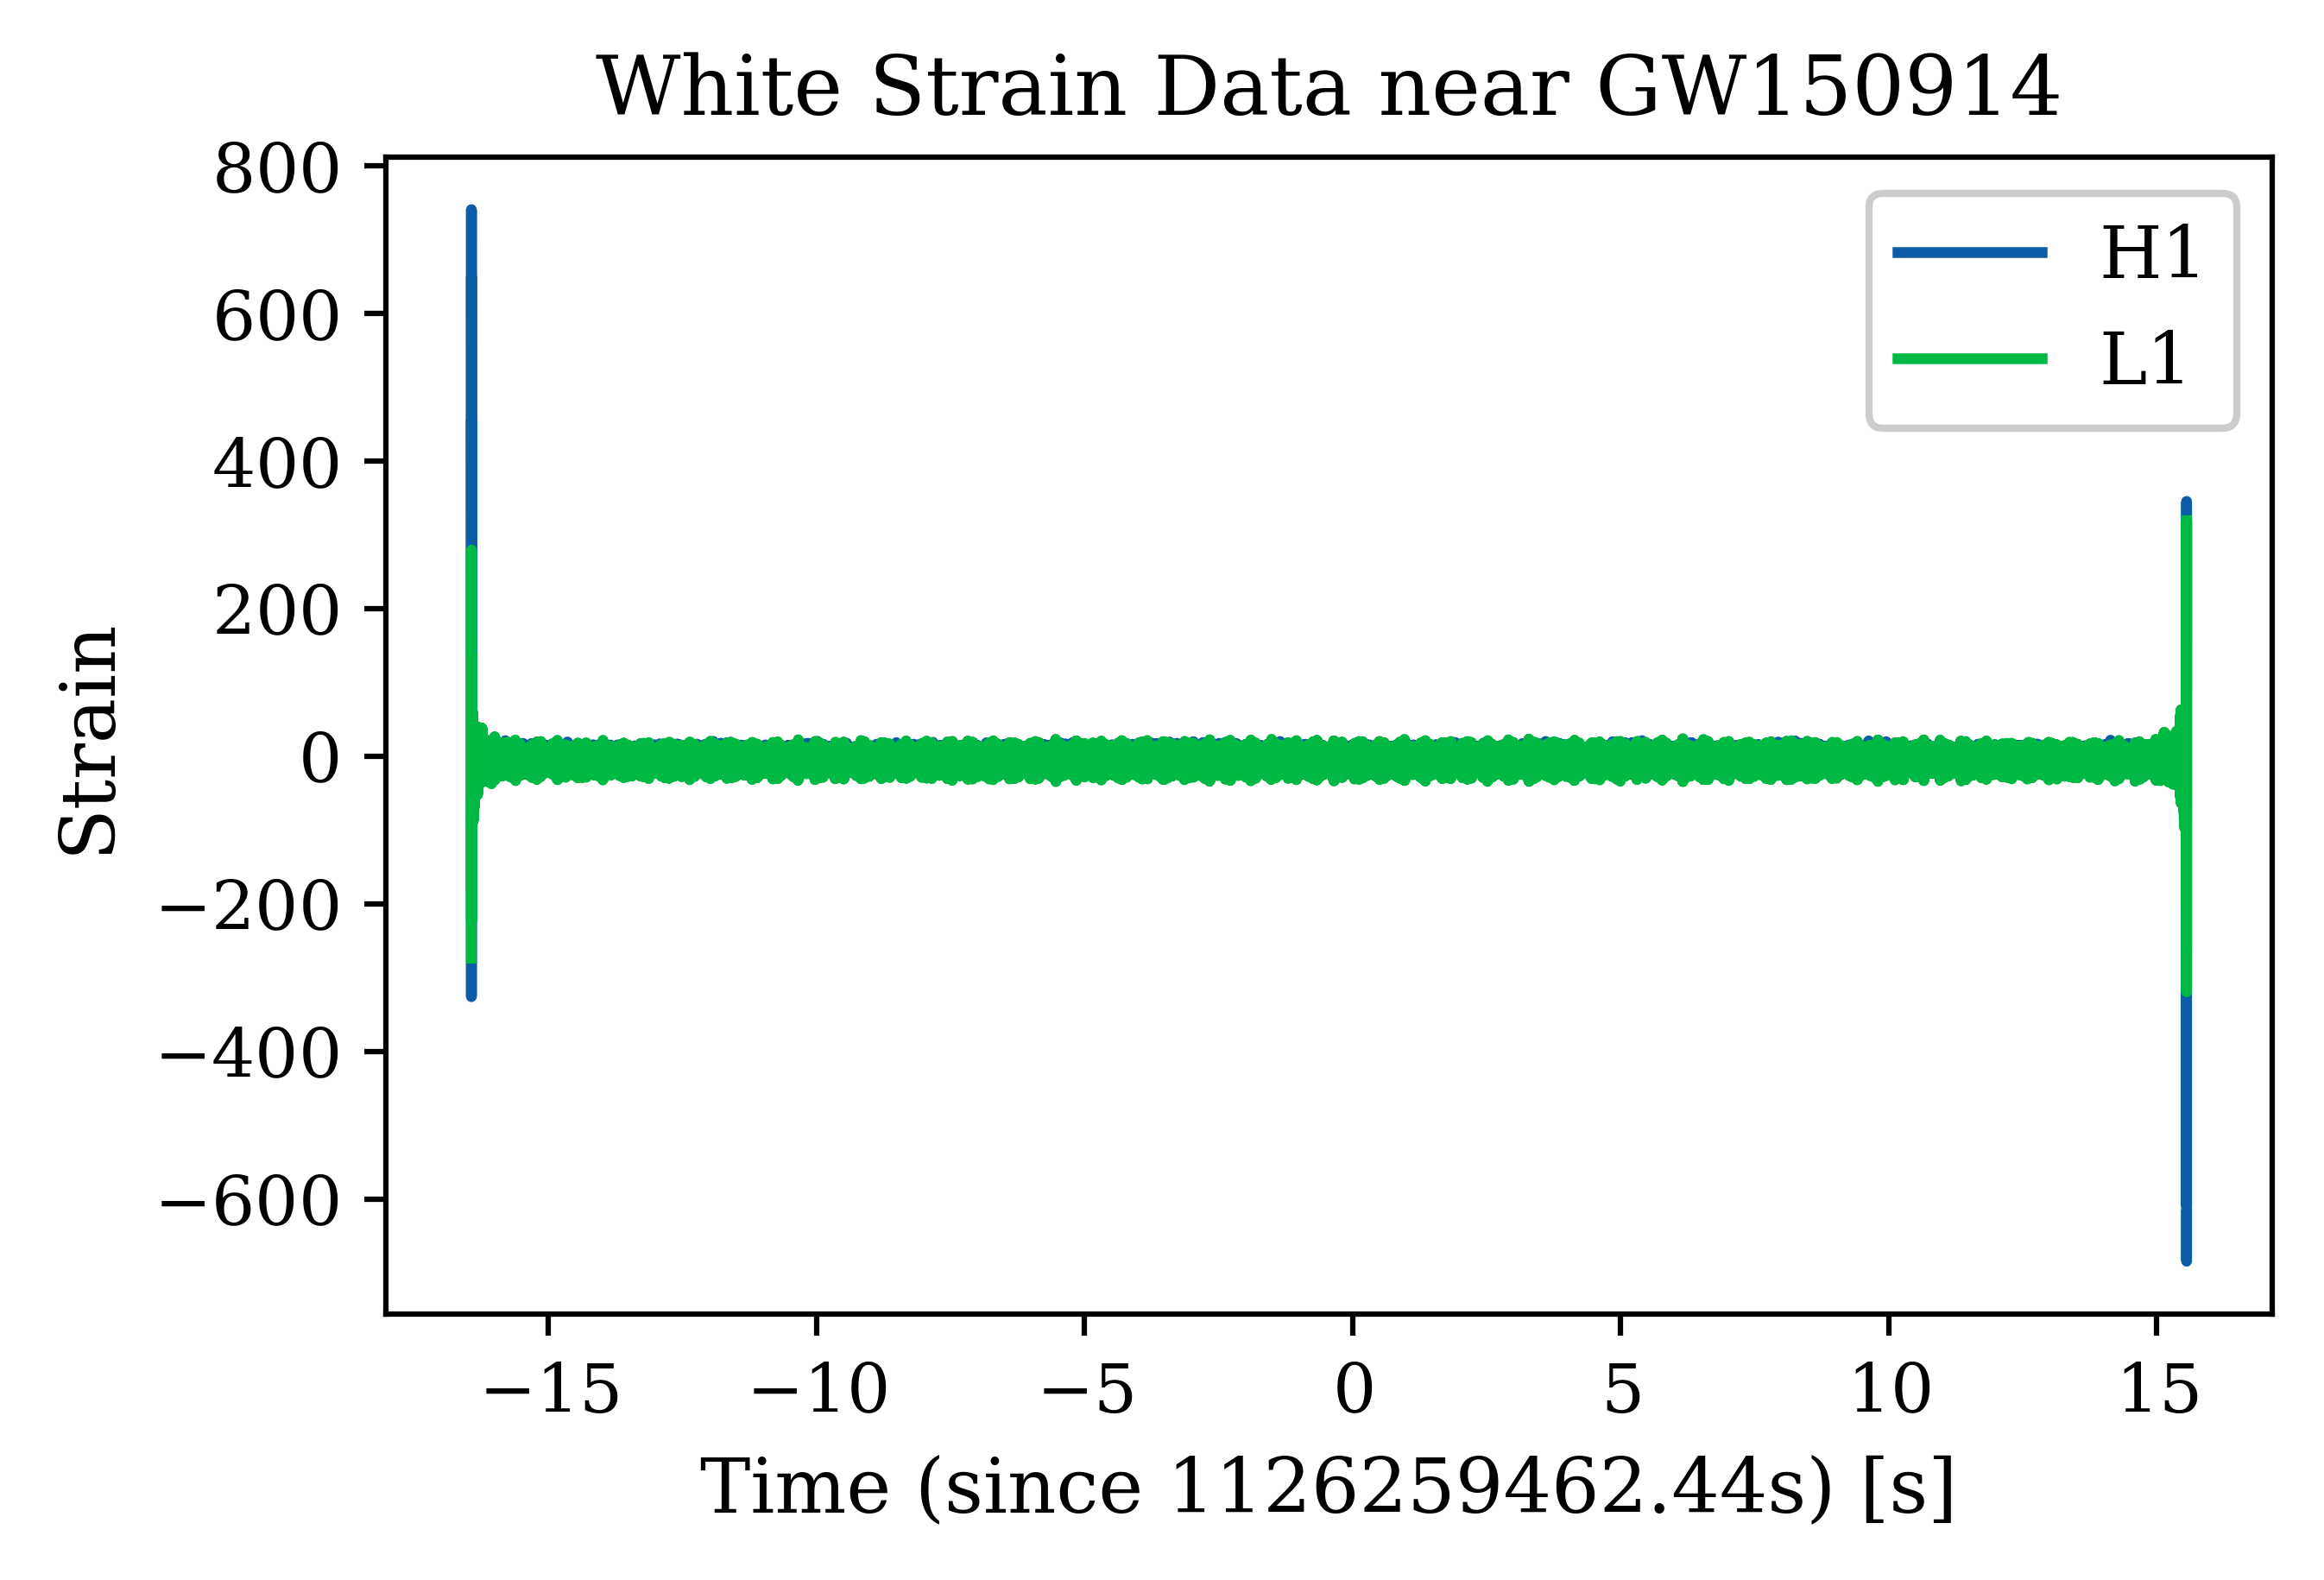

In [7]:
# 计算插值函数
from scipy.interpolate import interp1d

# 用一个很大的值来填充，或者用psd_H1的最后一个值
fill_value_H1 = psd_H1[-1] # 或者一个很大的数，例如 1e10
fill_value_L1 = psd_L1[-1]

psd_func_H1 = interp1d(f_H1, psd_H1, bounds_error=False, fill_value=fill_value_H1)
psd_func_L1 = interp1d(f_L1, psd_L1, bounds_error=False, fill_value=fill_value_L1)

norm = 1./np.sqrt(1./(dt*2)) # 归一化

# 白化
ft_H1 = np.fft.rfft(strain_H1)
Nt = len(strain_H1)
freqs = np.fft.rfftfreq(Nt, dt)
#freqs = np.linspace(0, 2048, Nt // 2 + 1)
white_ft_H1 = ft_H1 * norm / np.sqrt(psd_func_H1(freqs))
white_H1 = np.fft.irfft(white_ft_H1, n=Nt)

ft_L1 = np.fft.rfft(strain_L1)
Nt = len(strain_L1)
freqs = np.fft.rfftfreq(Nt, dt)
#freqs = np.linspace(0, 2048, Nt // 2 + 1)
white_ft_L1 = ft_L1 * norm / np.sqrt(psd_func_L1(freqs))
white_L1 = np.fft.irfft(white_ft_L1, n=Nt)

# 绘图
with ypu.temp_style(["ysy_academic", "science_color"]):
    ypu.plot(
        time[indxt]-t_event, (white_H1[indxt], white_L1[indxt]), ('H1', 'L1'), 
        'White Strain Data near GW150914', 'Time (since 1126259462.44s) [s]', 'Strain'
    )
    ypu.plot(
        time-t_event, (white_H1, white_L1), ('H1', 'L1'), 
        'White Strain Data near GW150914', 'Time (since 1126259462.44s) [s]', 'Strain'
    )

## 4 带通滤波

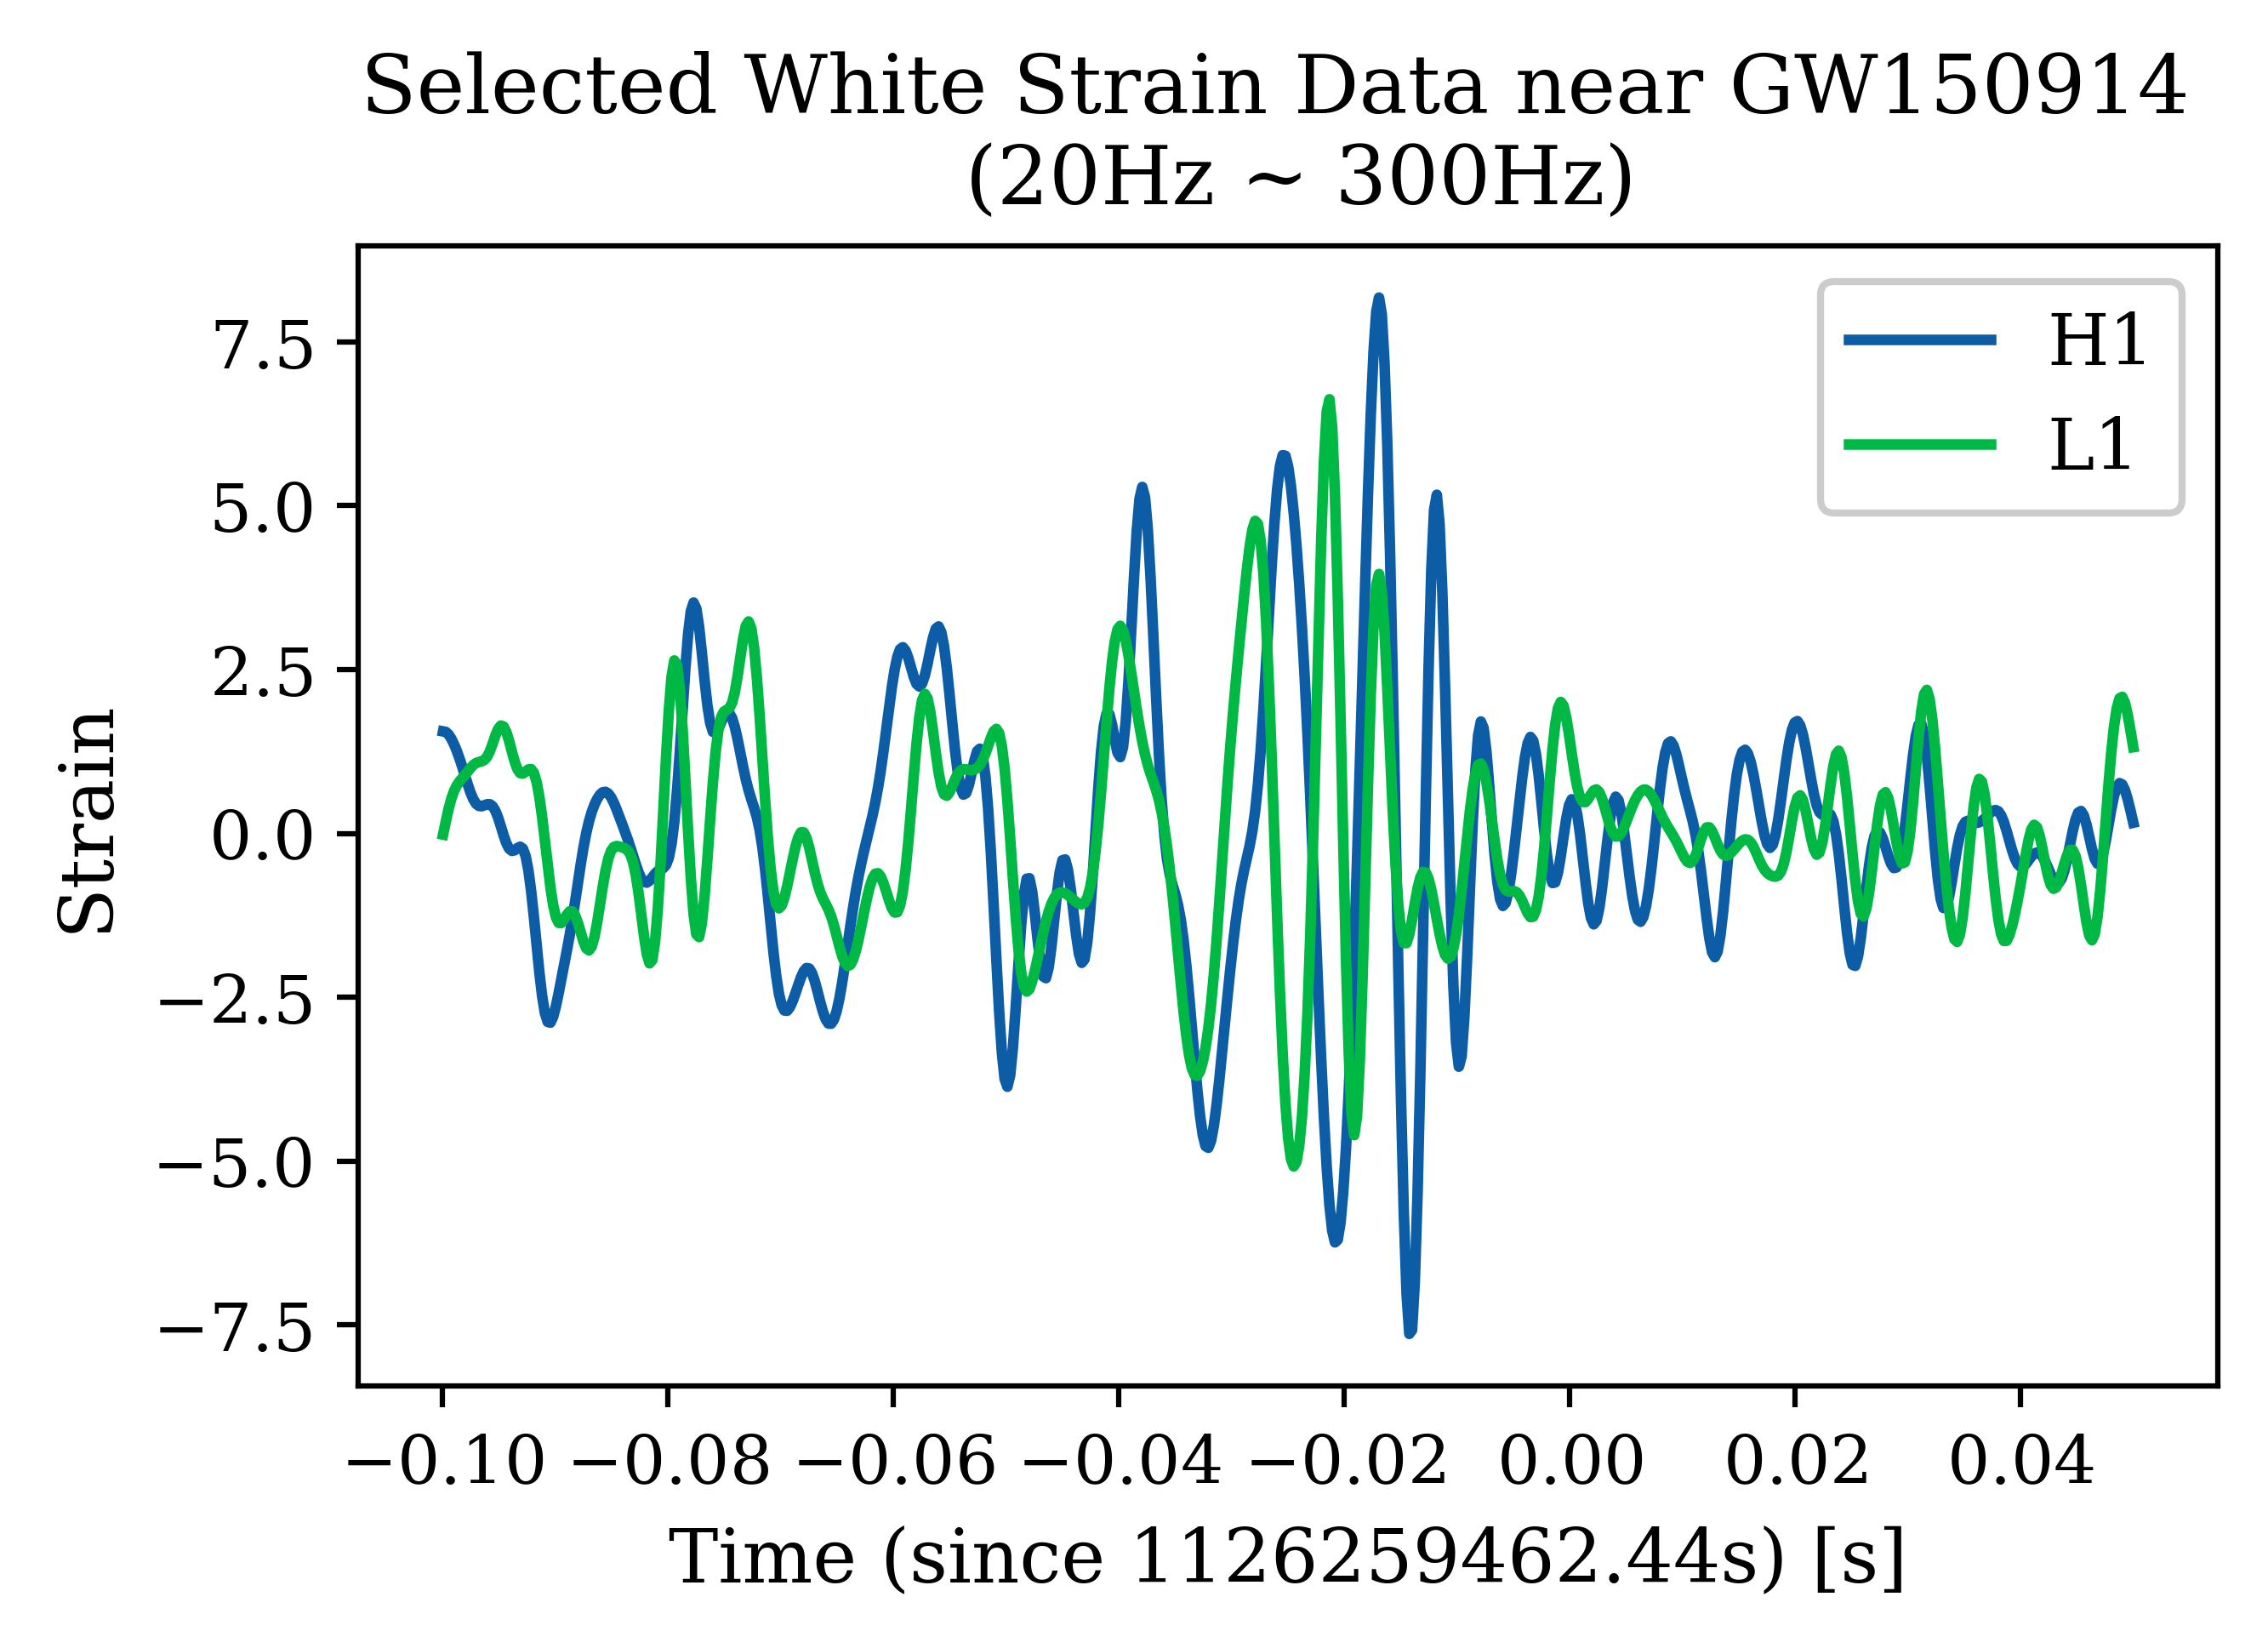

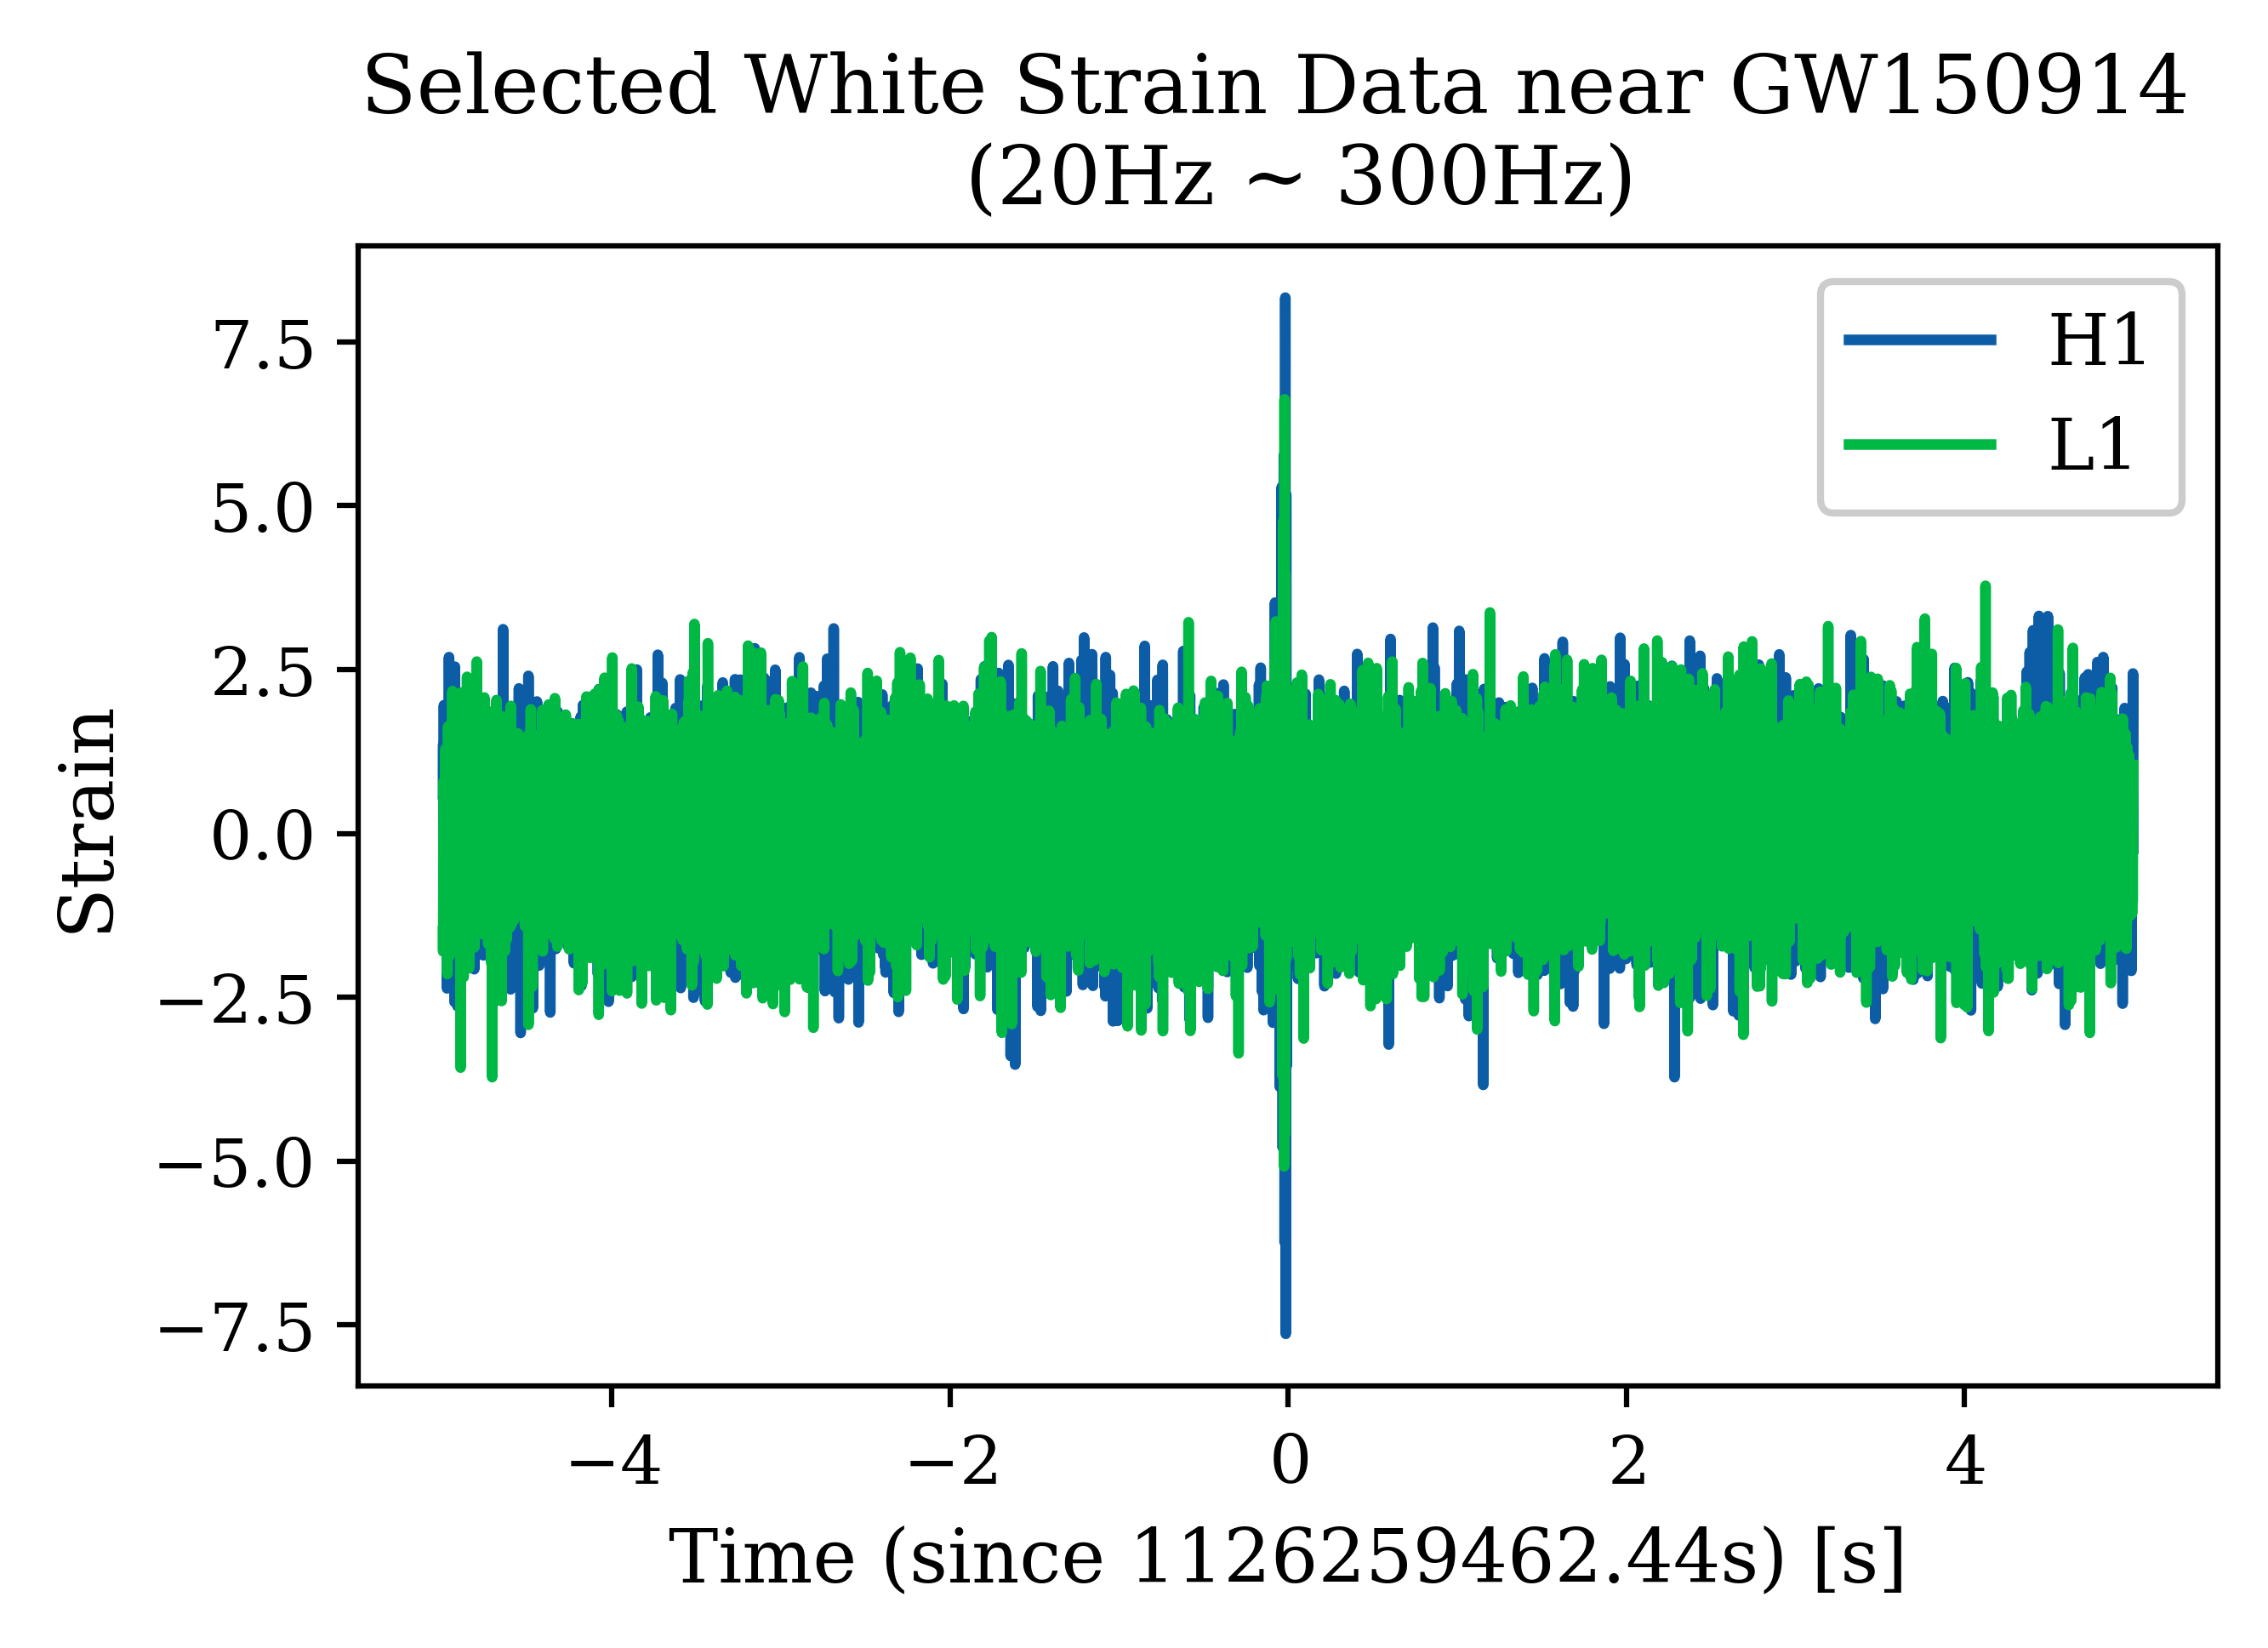

In [8]:
# 带通滤波
from scipy.signal import butter, filtfilt

fband = [20, 300] # 容许频段为 20Hz~300Hz

bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
normalization = np.sqrt((fband[1]-fband[0])/(fs/2))

selected_white_H1 = filtfilt(bb, ab, white_H1) / normalization
selected_white_L1 = filtfilt(bb, ab, white_L1) / normalization

# 重新选定绘图范围
delta_t2 = 0.1
delta_t3 = 0.05
indxt2 = np.where((time >= t_event-delta_t2) & (time < t_event+delta_t3))

with ypu.temp_style(["ysy_academic", "science_color"]):
    ypu.plot(
        time[indxt2]-t_event, (selected_white_H1[indxt2], selected_white_L1[indxt2]), ('H1', 'L1'), 
        'Selected White Strain Data near GW150914 \n (20Hz ~ 300Hz)', 'Time (since 1126259462.44s) [s]', 'Strain'
    )

# 对比一下
with ypu.temp_style(["ysy_academic", "science_color"]):
    ypu.plot(
        time[indxt]-t_event, (selected_white_H1[indxt], selected_white_L1[indxt]), ('H1', 'L1'), 
        'Selected White Strain Data near GW150914 \n (20Hz ~ 300Hz)', 'Time (since 1126259462.44s) [s]', 'Strain'
    )

## 5 匹配滤波

* 高信噪比
* 多探测器一致性
* 假警报率评估

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ysy_plot_utils as ypu
import ysy_gw_data_utils as ygdu

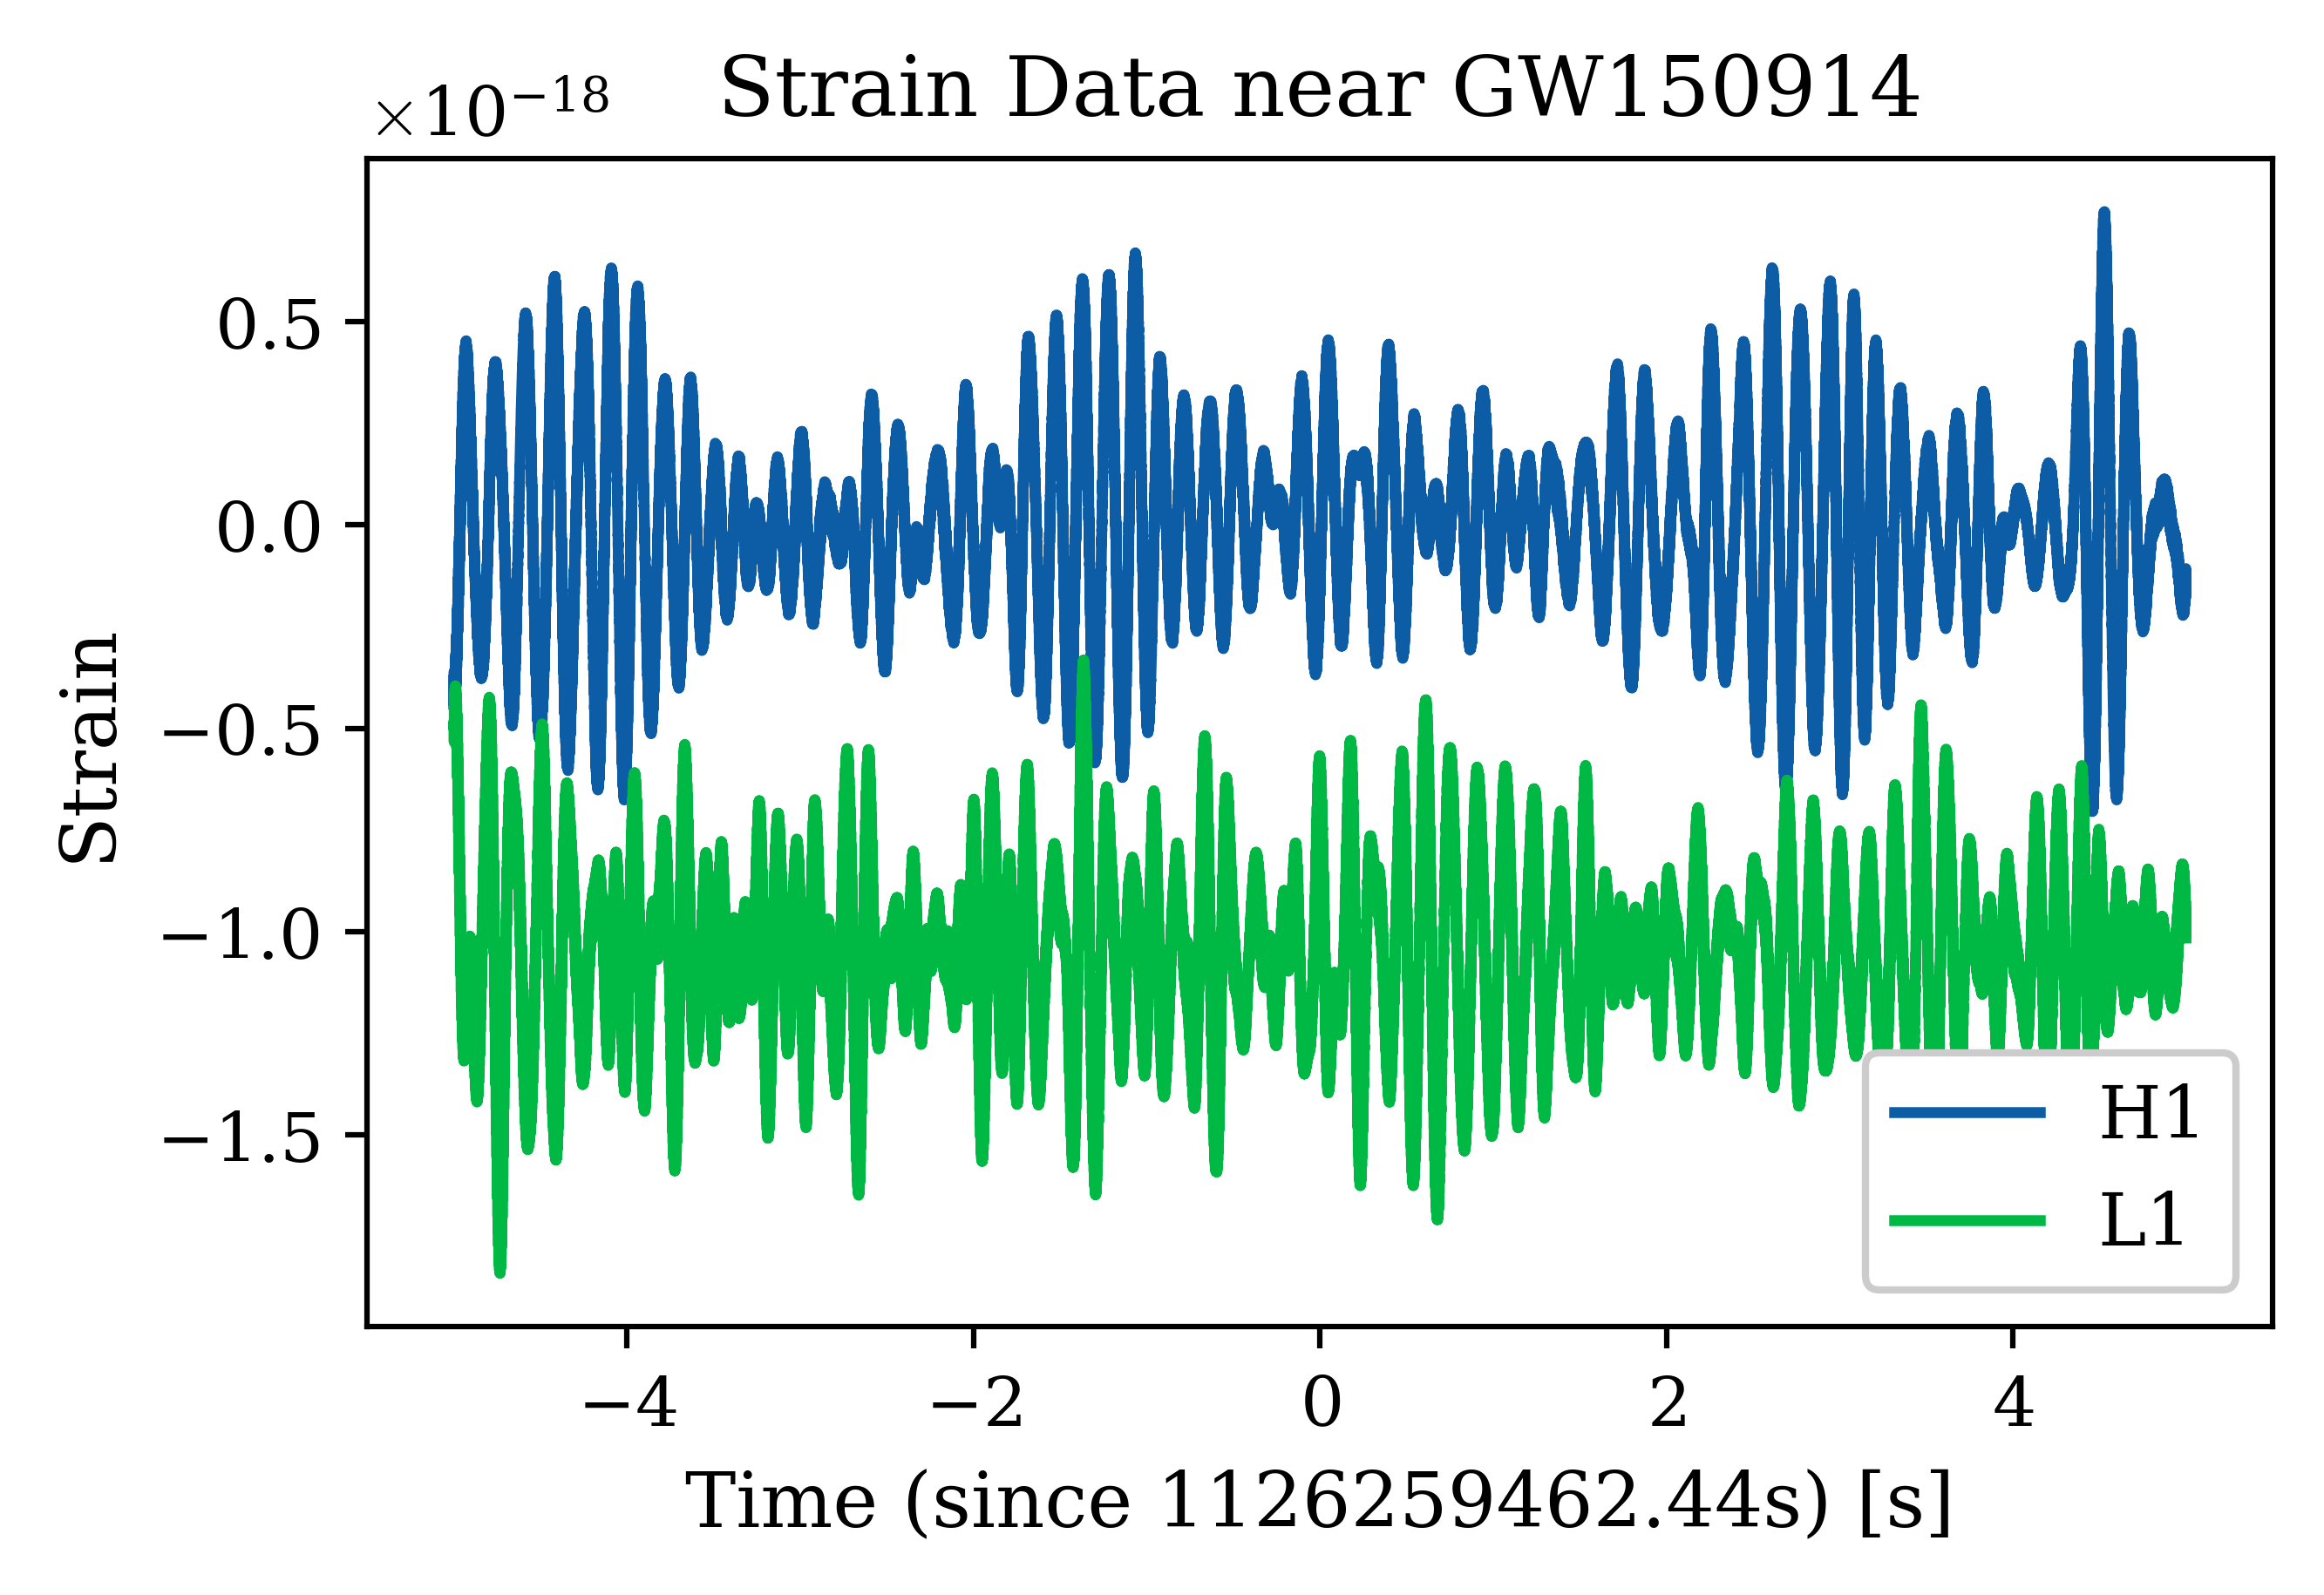

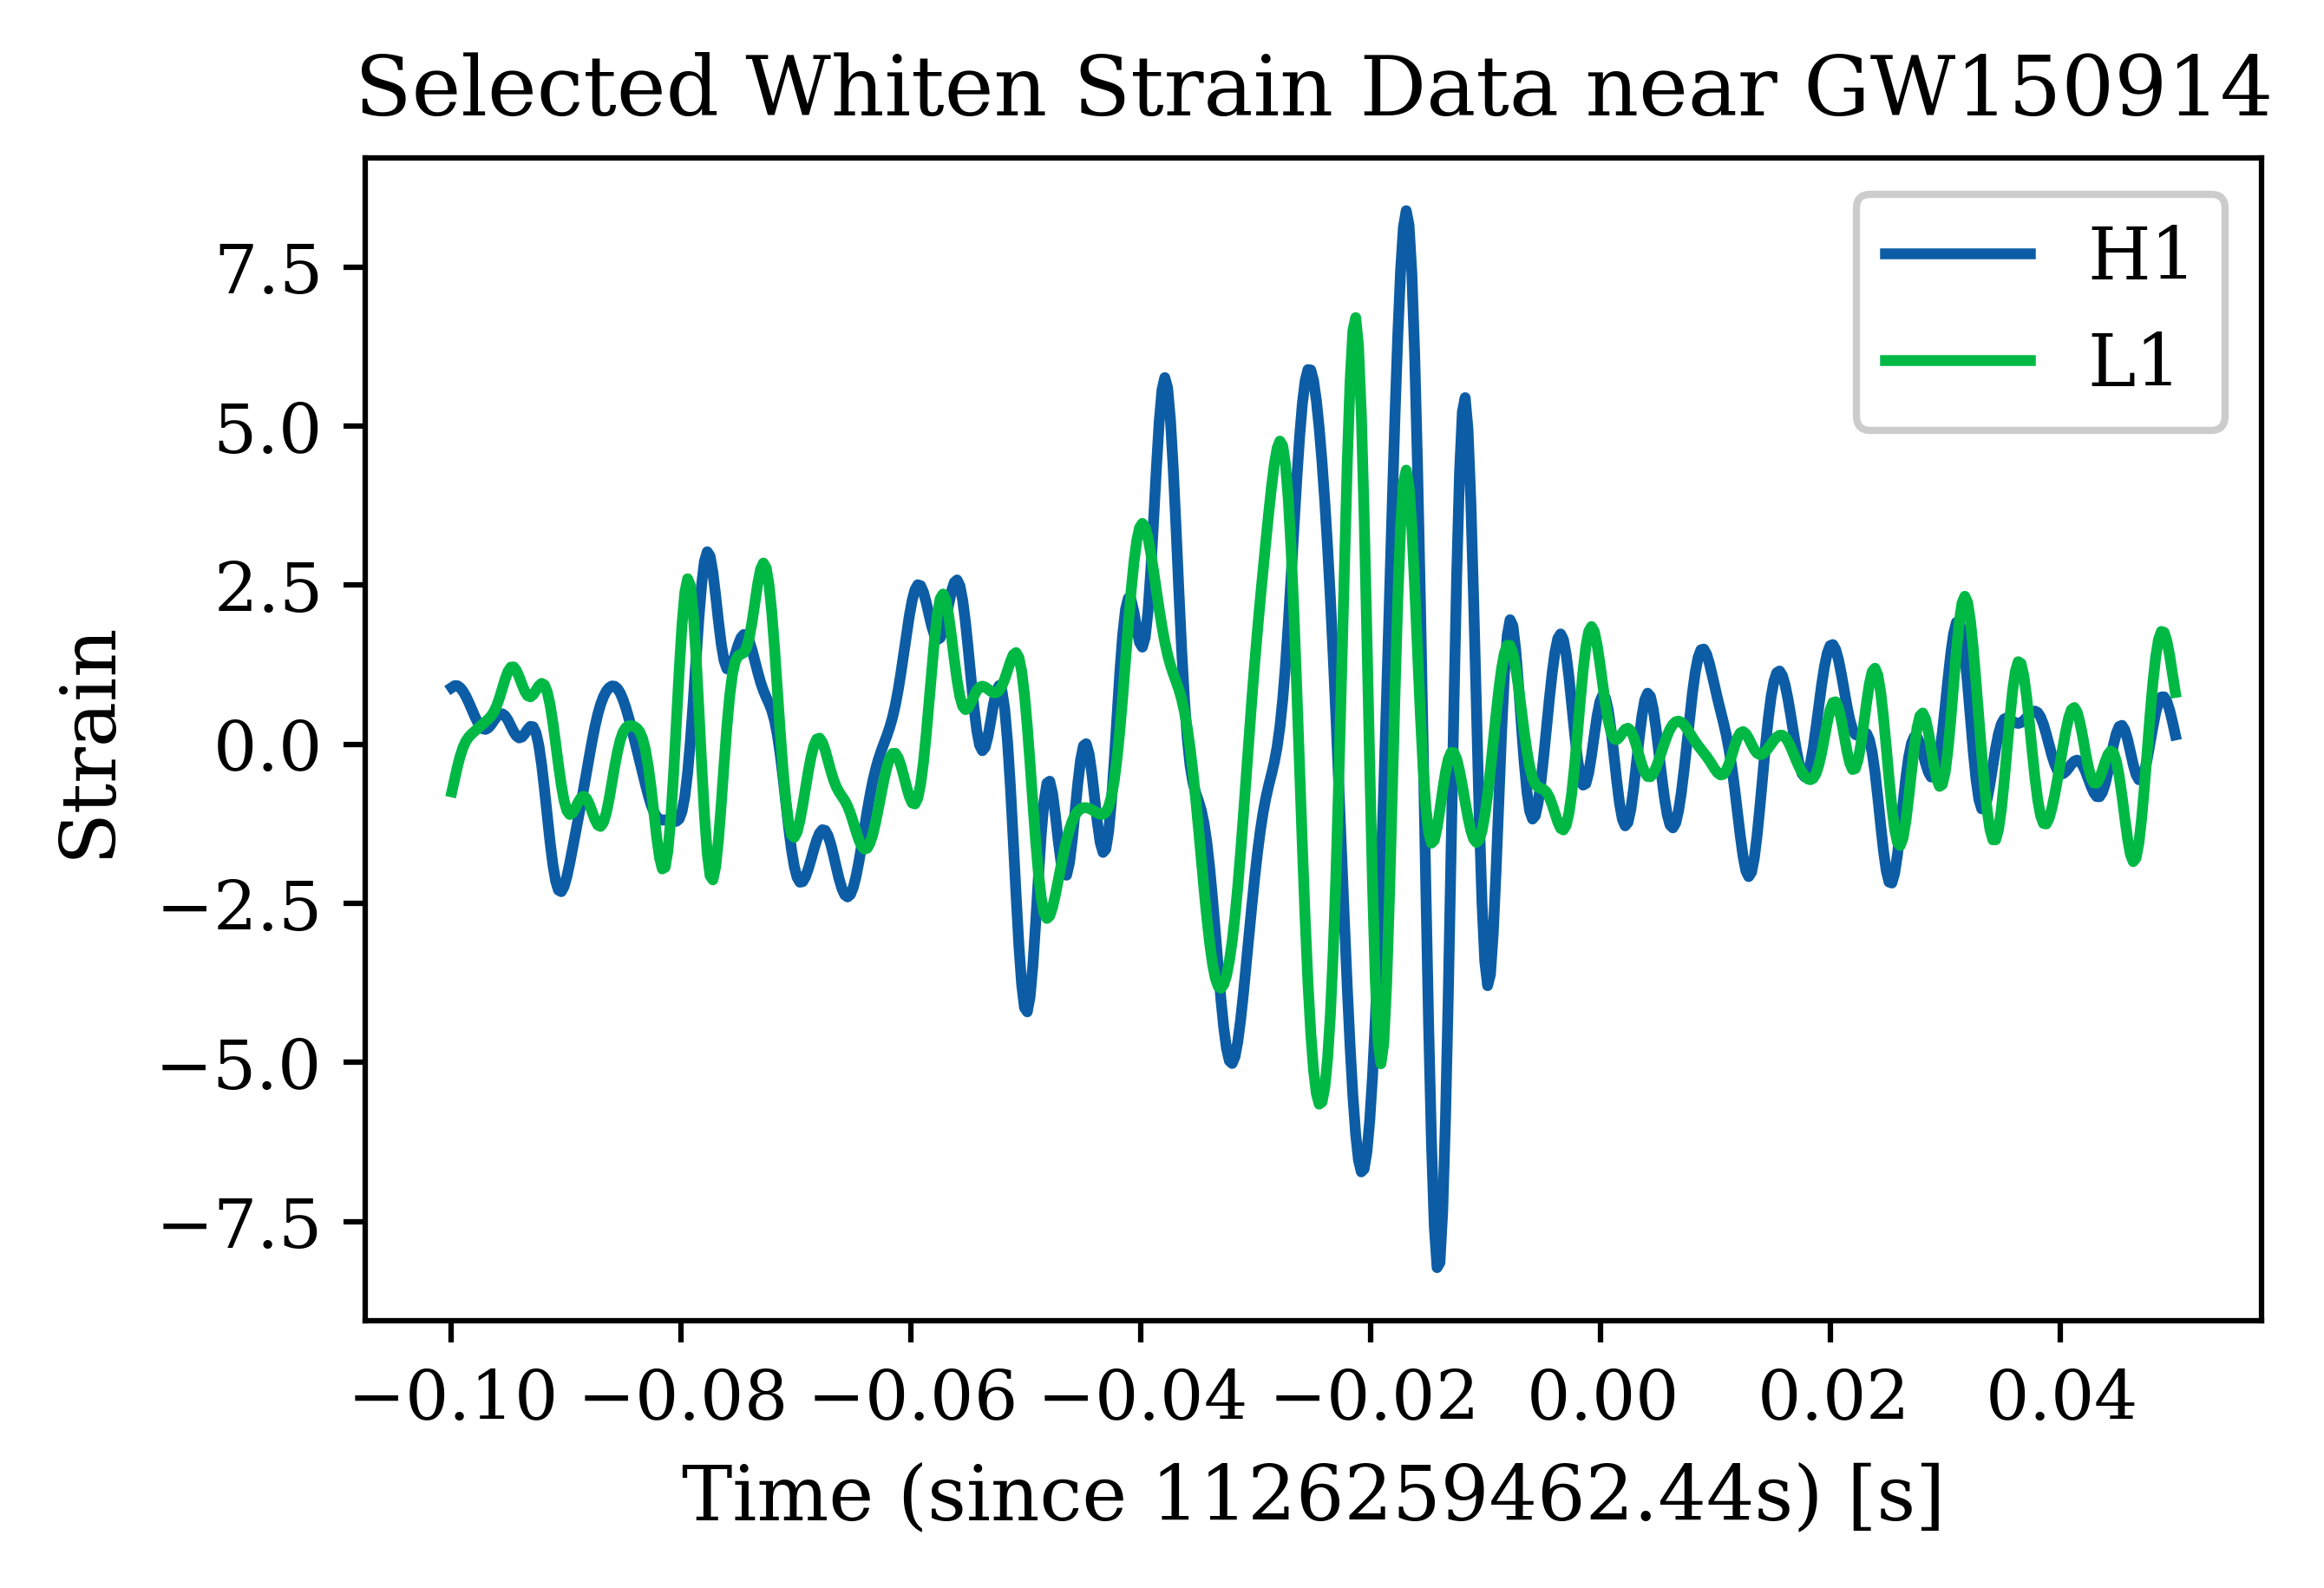

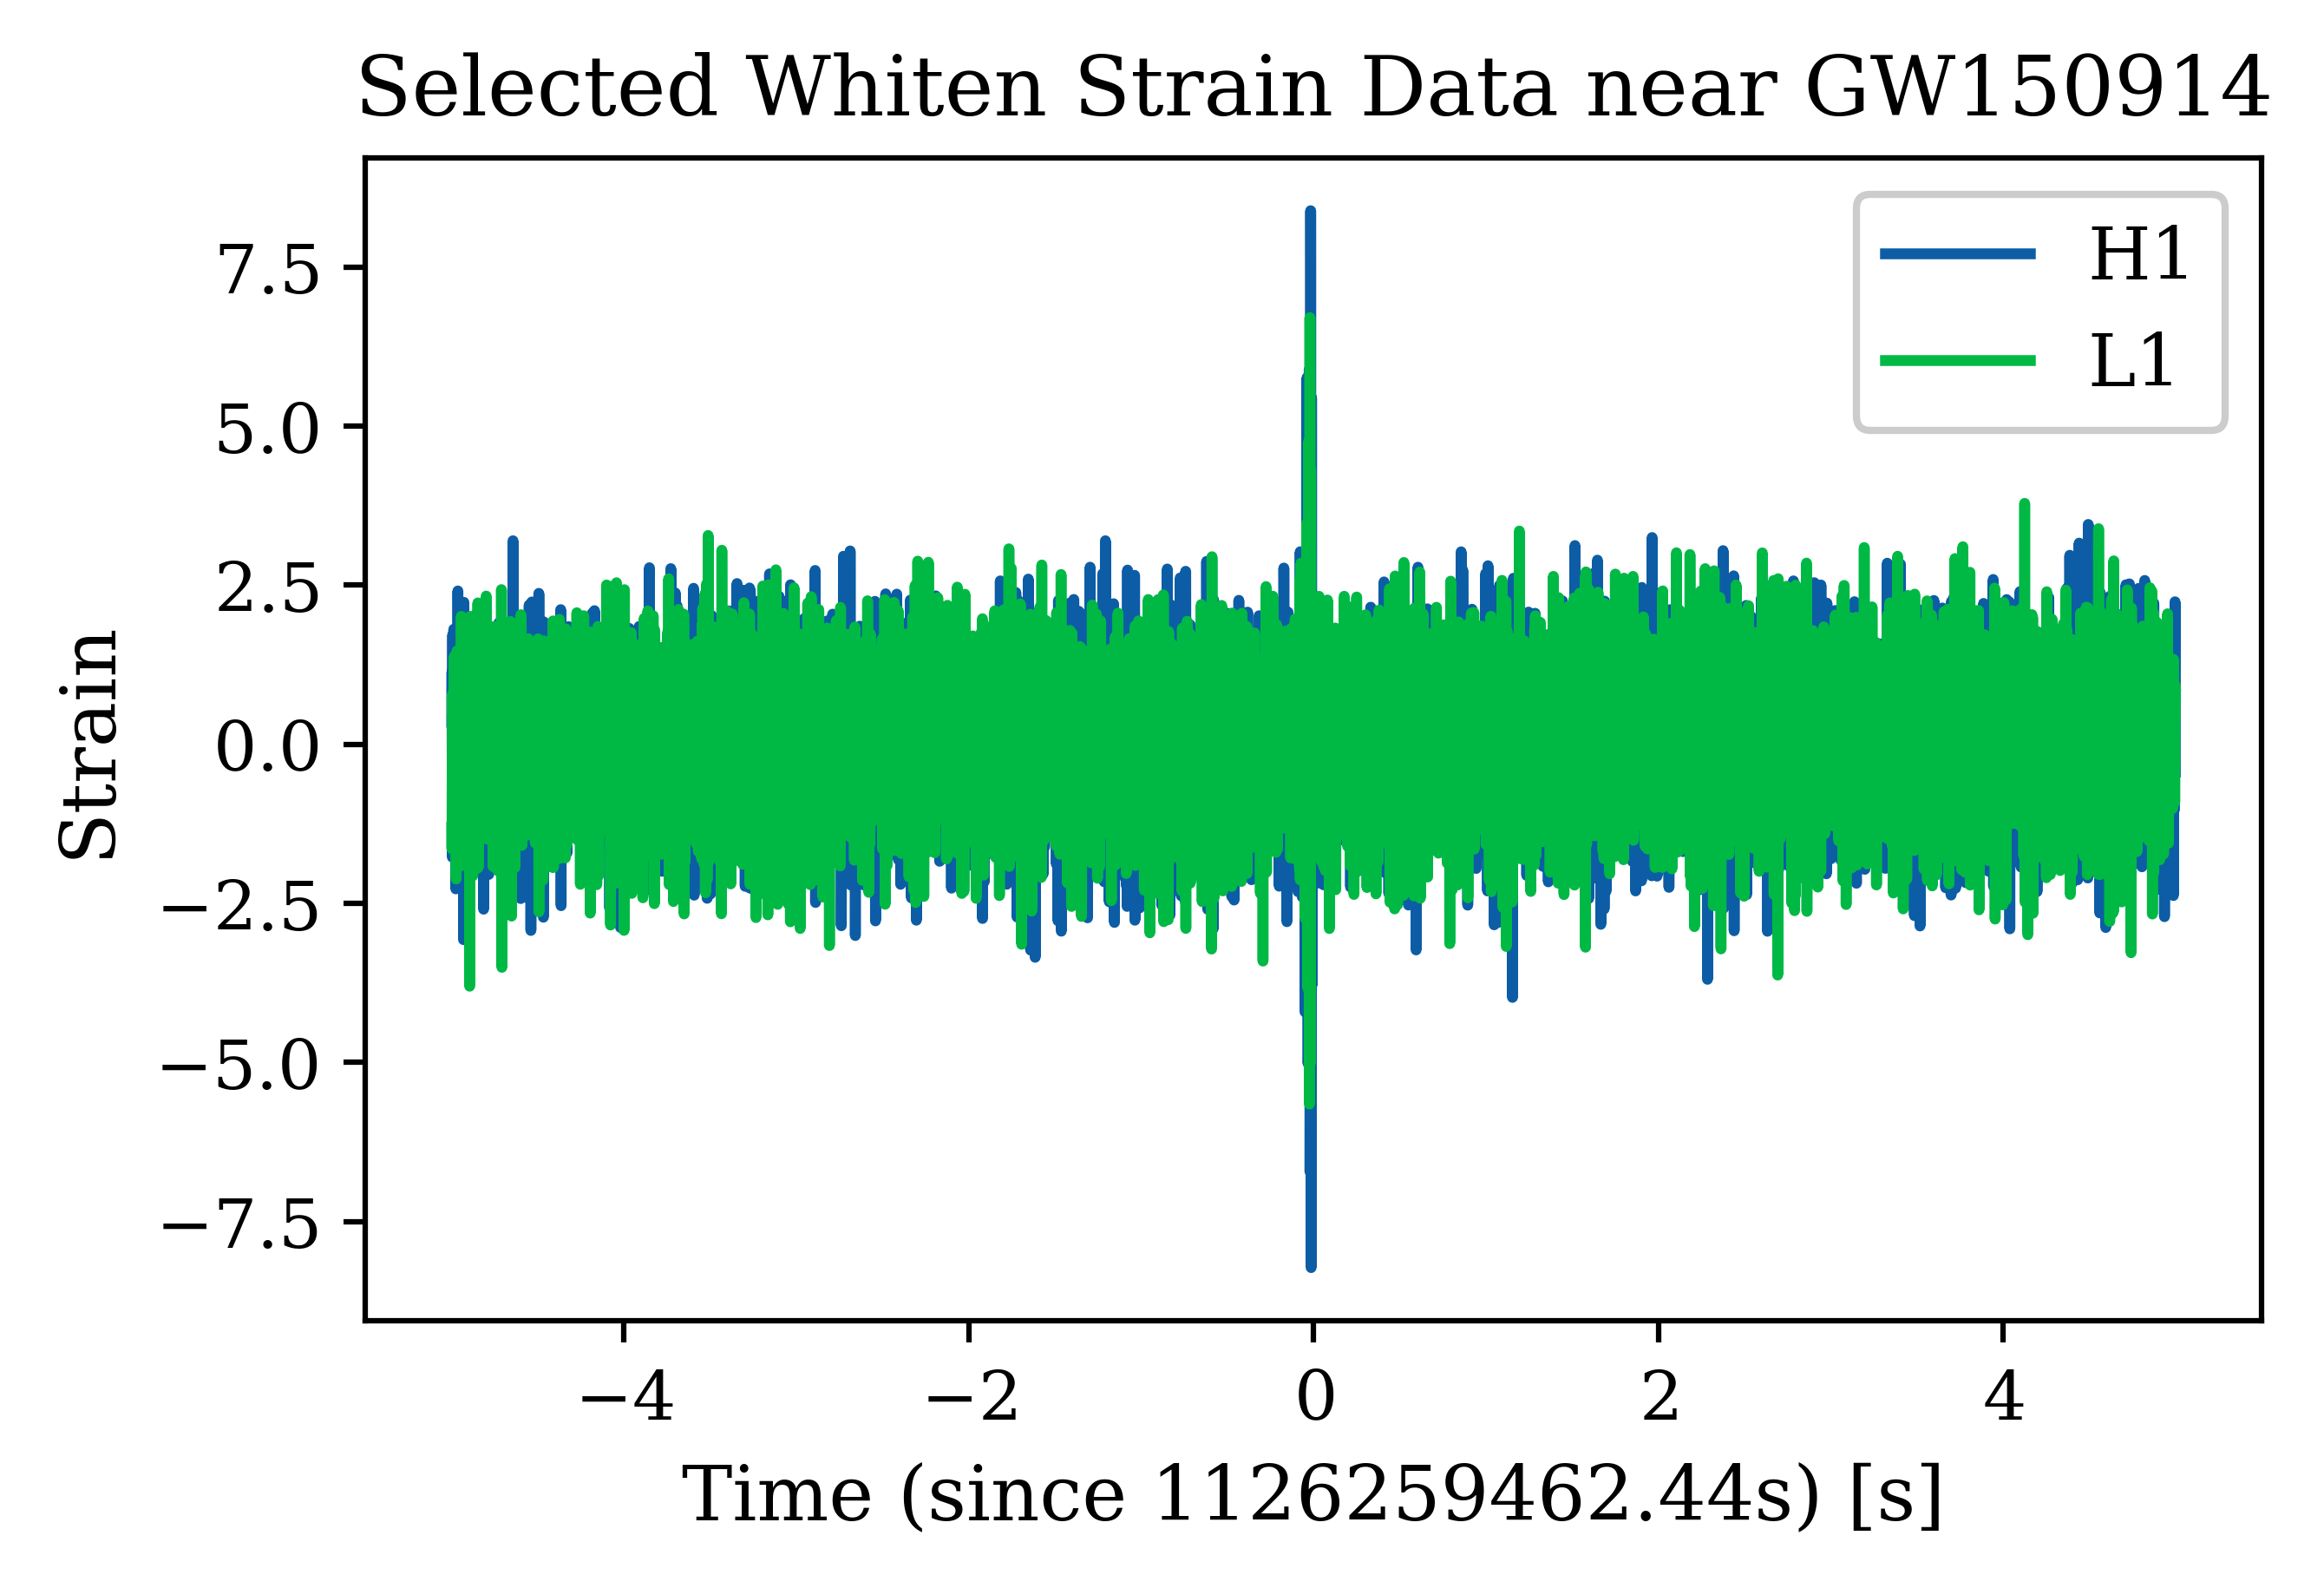

In [29]:
event_name = 'GW150914'
fs = 4096
t_event = 1126259462.44
fband = [43.0,300.0]
H1 = 'H1.csv'
L1 = 'L1.csv'

GW150914 = ygdu.PreProcessing(event_name, fs, t_event, fband, H1, L1)
data_GW150914 = GW150914.main()

strain_H1 = data_GW150914['strain_H1']
time_H1 = data_GW150914['time_H1']
strain_L1 = data_GW150914['strain_L1']
time_L1 = data_GW150914['time_L1']

time = time_H1
delta_t = 5
indxt = np.where((time >= t_event-delta_t) & (time < t_event+delta_t))
duration = 4
dt = time[1] - time[0]

with ypu.temp_style(["ysy_academic", "science_color"]):
    ypu.plot(
        time[indxt]-t_event, (strain_H1[indxt], strain_L1[indxt]), ('H1', 'L1'), 
        'Strain Data near '+event_name, 'Time (since '+str(t_event)+'s) [s]', 'Strain'
    )

selected_whiten_H1 = data_GW150914['selected_whiten_H1']
selected_whiten_L1 = data_GW150914['selected_whiten_L1']

delta_t2 = 0.1
delta_t3 = 0.05
indxt2 = np.where((time >= t_event-delta_t2) & (time < t_event+delta_t3))

with ypu.temp_style(["ysy_academic", "science_color"]):
    ypu.plot(
        time[indxt2]-t_event, (selected_whiten_H1[indxt2], selected_whiten_L1[indxt2]), ('H1', 'L1'), 
        'Selected Whiten Strain Data near '+event_name, 'Time (since '+str(t_event)+'s) [s]', 'Strain'
    )

with ypu.temp_style(["ysy_academic", "science_color"]):
    ypu.plot(
        time[indxt]-t_event, (selected_whiten_H1[indxt], selected_whiten_L1[indxt]), ('H1', 'L1'), 
        'Selected Whiten Strain Data near '+event_name, 'Time (since '+str(t_event)+'s) [s]', 'Strain'
    )

/Users/yangshuyun/anaconda3/envs/dplab/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:652: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


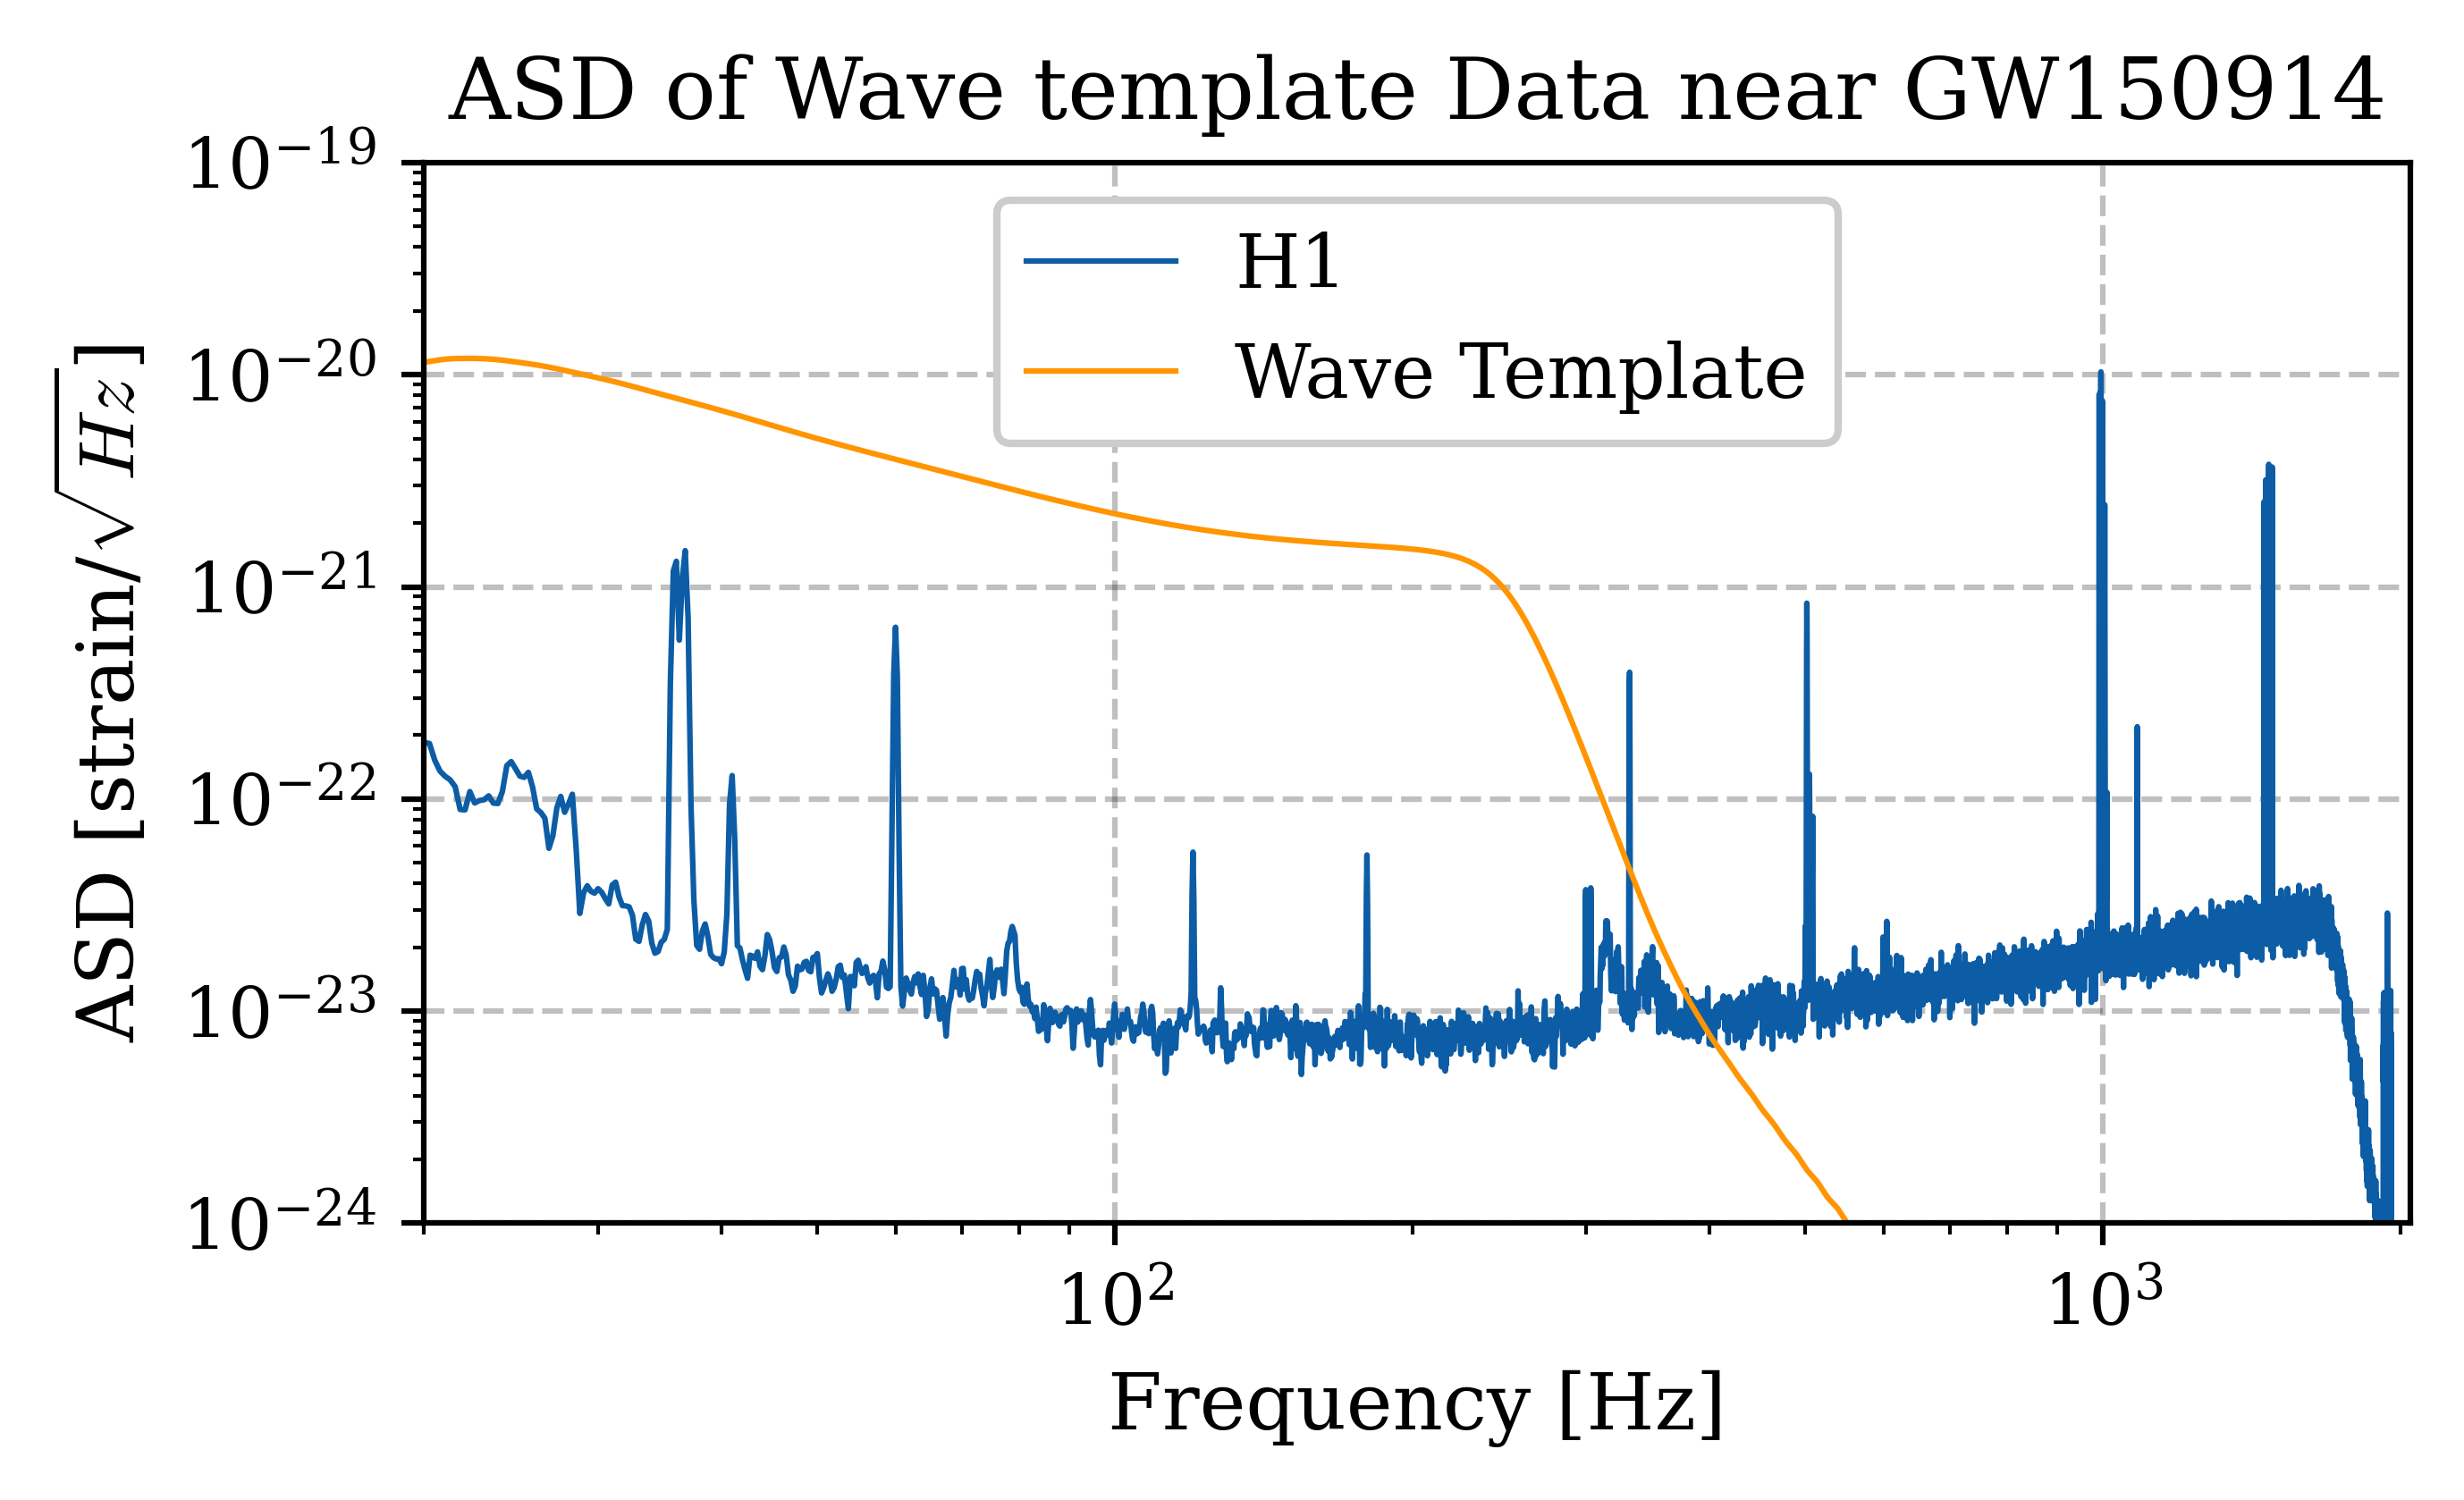

In [ ]:
psd_H1 = data_GW150914['psd_H1']
f_H1 = data_GW150914['f_H1']
psd_L1 = data_GW150914['psd_L1']
f_L1 = data_GW150914['f_L1']

# 加载模板
template_data = pd.read_csv('Template.csv')
template_p = template_data.iloc[0].values
template_c = template_data.iloc[1].values

template = template_p + 1j * template_c

f_template, psd_template = ygdu.get_PSD(template, fs, duration)
asd_template = np.sqrt(psd_template) # ASD 是 PSD 的平方根

# 绘图
with ypu.temp_style(["ysy_academic", "science_color"]):
    plt.figure()
    plt.loglog(f_H1, np.sqrt(psd_H1), label='H1', linewidth=0.75, color='C0')
    plt.loglog(f_template, asd_template, label='Wave Template', linewidth=0.75, color='C2')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('ASD [strain/$\sqrt{Hz}$]')
    plt.title('ASD of Wave template Data near '+event_name)
    plt.legend()
    plt.grid(alpha=0.25)
    plt.xlim(20, fs / 2)
    plt.ylim(1e-24, 1e-19)
    plt.tight_layout()
    plt.show()


In [55]:
# 信噪比——白化

from scipy import signal

def prepare_whitened_template(template, psd, freqs, fs, dt):
    """
    根据探测器的噪声PSD，准备白化后的频率域模板。
    此函数严格遵循先合并、再变换、后白化的标准流程。
    
    参数:
    template_p: array, h_plus 时间域模板
    template_c: array, h_cross 时间域模板
    psd: array, 探测器的功率谱密度
    freqs: array, 与PSD对应的频率数组
    fs: int, 采样率
    
    返回:
    template_fft_whitened: array, 白化后的频率域复数模板
    """
    # 获取数据长度和时间/频率步长
    N = len(template)
    try:
        # 修正后的调用路径
        dwindow = signal.windows.tukey(N, alpha=1./8)
    except AttributeError:
        # 修正后的备用方案调用路径
        dwindow = signal.windows.blackman(template.size)       # Blackman window OK if Tukey is not available
    
    # 步骤2：计算这个复数模板的傅里叶变换
    # 注意：教程中还包含了一个窗口函数(dwindow)，这是一个优化细节，
    # 用于减少数据段边缘的频谱泄漏效应。我们这里为了聚焦核心逻辑可以暂时省略，
    # 但在精密计算中是必要的。
    template_fft = np.fft.fft(template*dwindow) / fs
    
    # 步骤3：将探测器的PSD插值到模板FFT所对应的频率点上
    # 这是至关重要的一步，确保我们在每个频率上都用正确的噪声水平来归一化
    # 对应官方教程的: power_vec = np.interp(...)
    fft_freqs = np.fft.fftfreq(N, d=dt)
    
    # 我们只对正频率进行插值，因为负频率的PSD与正频率对称
    # 为避免插值范围问题和零频问题，通常从第一个非零频率点开始
    try:
        power_vec = np.interp(np.abs(fft_freqs), freqs, psd)
    except Exception as e:
        # 增加错误检查，如果插值失败则提示
        print(f"PSD插值时发生错误: {e}")
        print("请检查 freqs 和 psd 数组是否有效。")
        return None

    # 步骤4：对模板FFT进行白化
    # 白化的本质是在频率域上除以噪声的幅值谱密度(ASD = sqrt(PSD))
    # 为避免除以零，给分母增加一个极小值或者将零值替换
    asd_vec = np.sqrt(power_vec)
    asd_vec[asd_vec == 0] = np.inf # 将ASD为0的点设为无穷大，这样白化后会变为0
    
    template_fft_whitened = template_fft / asd_vec
    
    # 保证直流分量(0Hz)为0
    template_fft_whitened[fft_freqs == 0] = 0
    
    return template_fft_whitened, asd_vec

whiten_ft_template_H1, asd_vec = prepare_whitened_template(template, psd_H1, f_H1, fs, dt)
whiten_ft_template_L1 = prepare_whitened_template(template, psd_L1, f_L1, fs, dt)[0]

In [64]:
def calculate_snr_from_whitened(data_whitened, template_fft_whitened, fs, dt):
    """
    使用白化的数据和白化的频率域模板计算SNR时间序列。
    
    参数:
    data_whitened: array, 时间域的白化探测器数据
    template_fft_whitened: array, 频率域的白化复数模板
    fs: int, 采样率
    
    返回:
    snr: array, SNR时间序列
    """
    # 获取数据长度和时间/频率步长
    N = len(data_whitened)
    df = fs / N

    try:
        # 修正后的调用路径
        dwindow = signal.windows.tukey(N, alpha=1./8)
    except AttributeError:
        # 修正后的备用方案调用路径
        dwindow = signal.windows.blackman(template.size) 
    
    # 步骤1：将时间域的白化数据进行傅里叶变换
    # 也许要修正回去（也就是重新补偿回归一化因子norm，教程里是没有用
    # 原来的whiten函数的，也就是不会去多乘上一个norm），要不然就得按下面另一个方案来
    norm = 1./np.sqrt(1./(dt*2))
    data_fft_whitened = np.fft.fft(data_whitened*dwindow) / (fs*norm)
    
    # 步骤2：计算归一化因子 sigma
    # sigma^2 是白化模板在频率域的能量总和
    # 对应公式 sigma^2 = sum(|template_w(f)|^2 * df)
    sigmasq = np.sum(template_fft_whitened*template_fft_whitened.conj()) * df
    sigma = np.sqrt(np.abs(sigmasq))
    
    # 步骤3：频率域相乘（相关性计算）
    # 将白化数据的FFT与白化模板FFT的复共轭相乘
    mf_fft = data_fft_whitened * template_fft_whitened.conj()
    
    # 步骤4：逆傅里叶变换回时间域
    # 乘 fs 是ifft的归一化约定
    mf_time = 2*np.fft.ifft(mf_fft) * fs
    
    # 步骤5：归一化得到SNR
    snr_complex = mf_time / sigma
    
    # 这是一个惯例，将结果滚动，使峰值时间对应于事件发生的时间
    peaksample = N // 2
    snr_shifted = np.roll(snr_complex, shift=peaksample)

    # 结果
    # 信噪比
    snr = np.abs(snr_shifted)

    # 相位信息
    indmax = np.argmax(snr)
    phase = np.angle(snr_shifted[indmax])

    # 偏移
    offset = (indmax-peaksample)

    # 有效距离
    peak_snr = np.max(snr)
    d_eff = sigma / peak_snr
    
    return snr, phase, offset, d_eff

# 注意用的是没有带通滤波的白化数据

whiten_H1 = data_GW150914['whiten_H1']
snr_H1, phase_H1, offset_H1, d_eff_H1 = calculate_snr_from_whitened(
    whiten_H1, 
    whiten_ft_template_H1, 
    fs, 
    dt
)

# --- 寻找并输出峰值结果 ---
# H1
peak_snr_H1 = np.max(snr_H1)
peak_index_H1 = np.argmax(snr_H1)
peak_time_H1 = time_H1[peak_index_H1]
print("We find max SNR", peak_snr_H1, 'at', peak_time_H1, 's with the effctive distance', d_eff_H1, '.')

We find max SNR 18.83303273705522 at 1126259462.4394531 s with the effctive distance 803.0128006605973 .


In [60]:
# 参考教程给出的另一方案，用原始数据计算

def calculate_snr(data, template_fft_whitened, fs, asd_vec):
    # 获取数据长度和时间/频率步长
    N = len(data)
    df = fs / N
    duration = 4

    try:
        # 修正后的调用路径
        dwindow = signal.windows.tukey(N, alpha=1./8)
    except AttributeError:
        # 修正后的备用方案调用路径
        dwindow = signal.windows.blackman(template.size)

    f, psd = ygdu.get_PSD(data ,fs, duration)
    
    data_fft = np.fft.fft(data*dwindow) / fs

    sigmasq = np.sum(template_fft_whitened*template_fft_whitened.conj()) * df
    sigma = np.sqrt(sigmasq)
    
    # 步骤3：频率域相乘（相关性计算）
    # 将白化数据的FFT与白化模板FFT的复共轭相乘
    mf_fft = data_fft * template_fft_whitened.conj() / asd_vec
    
    # 步骤4：逆傅里叶变换回时间域
    # 乘 fs 是ifft的归一化约定
    mf_time = 2*np.fft.ifft(mf_fft) * fs
    
    # 步骤5：归一化得到SNR
    snr_complex = mf_time / sigma
    snr = np.abs(snr_complex)
    
    # 这是一个惯例，将结果滚动，使峰值时间对应于事件发生的时间
    snr_shifted = np.roll(snr, shift=N // 2)
    
    return snr_shifted

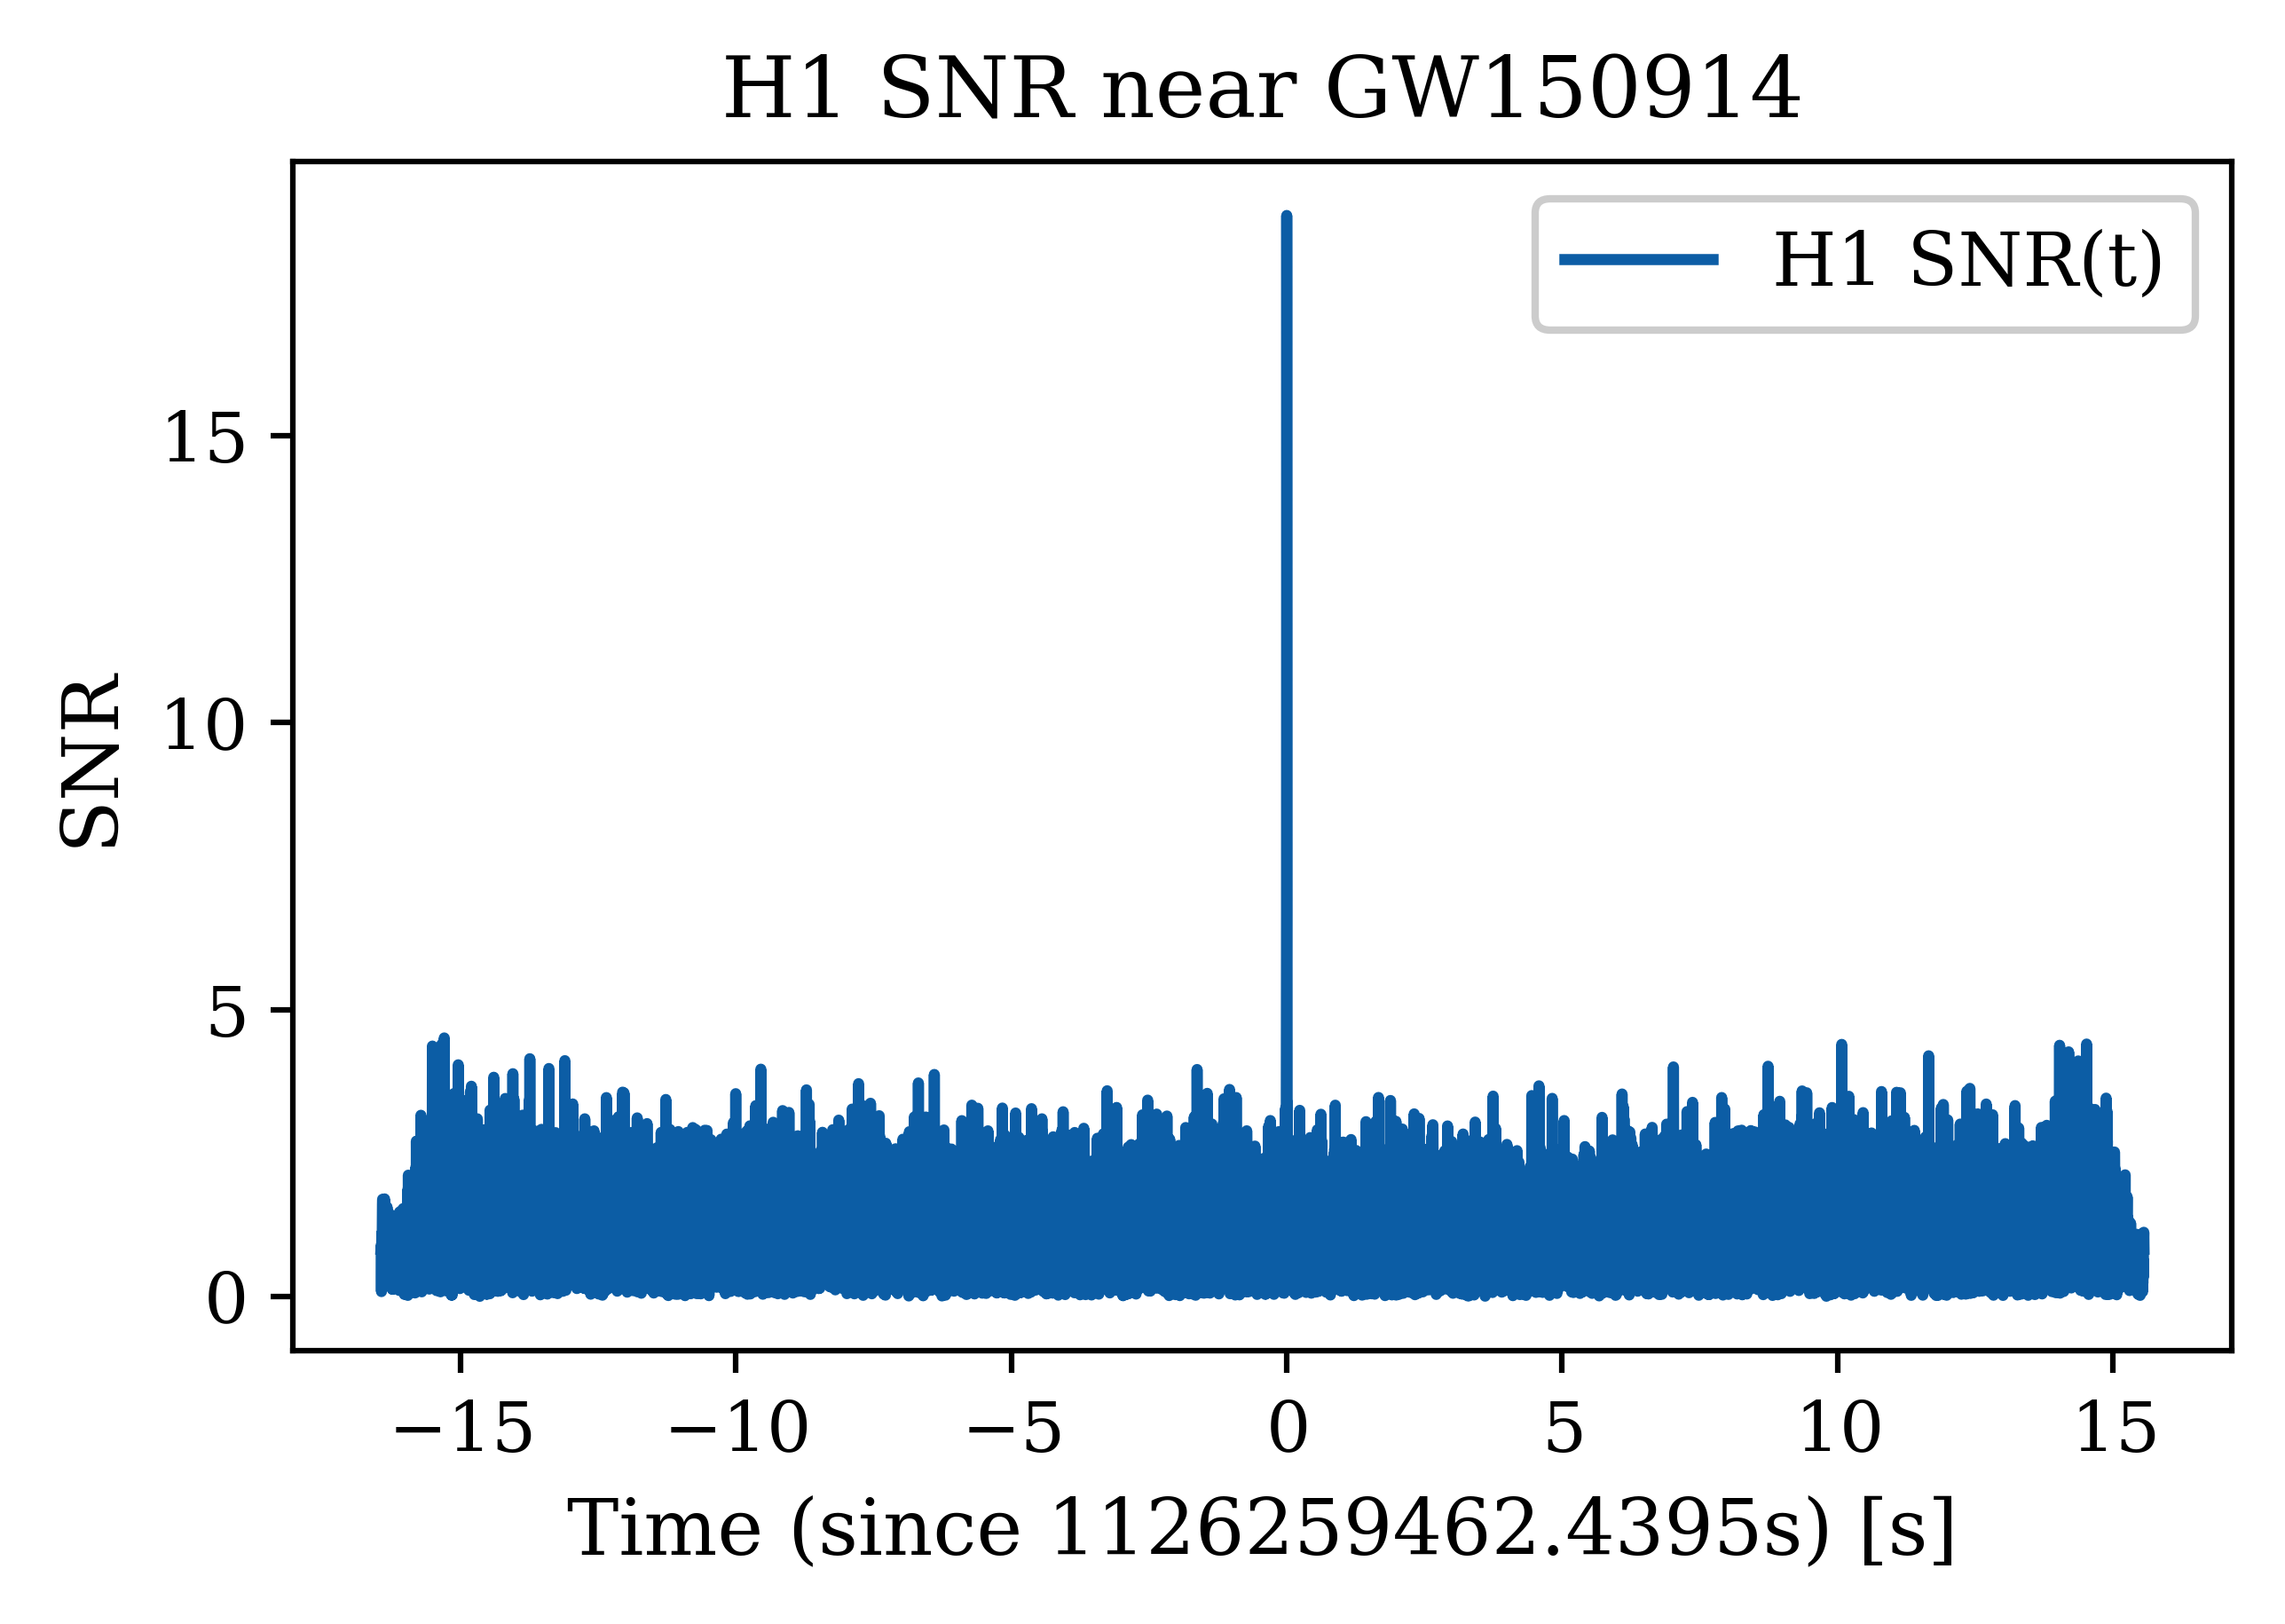

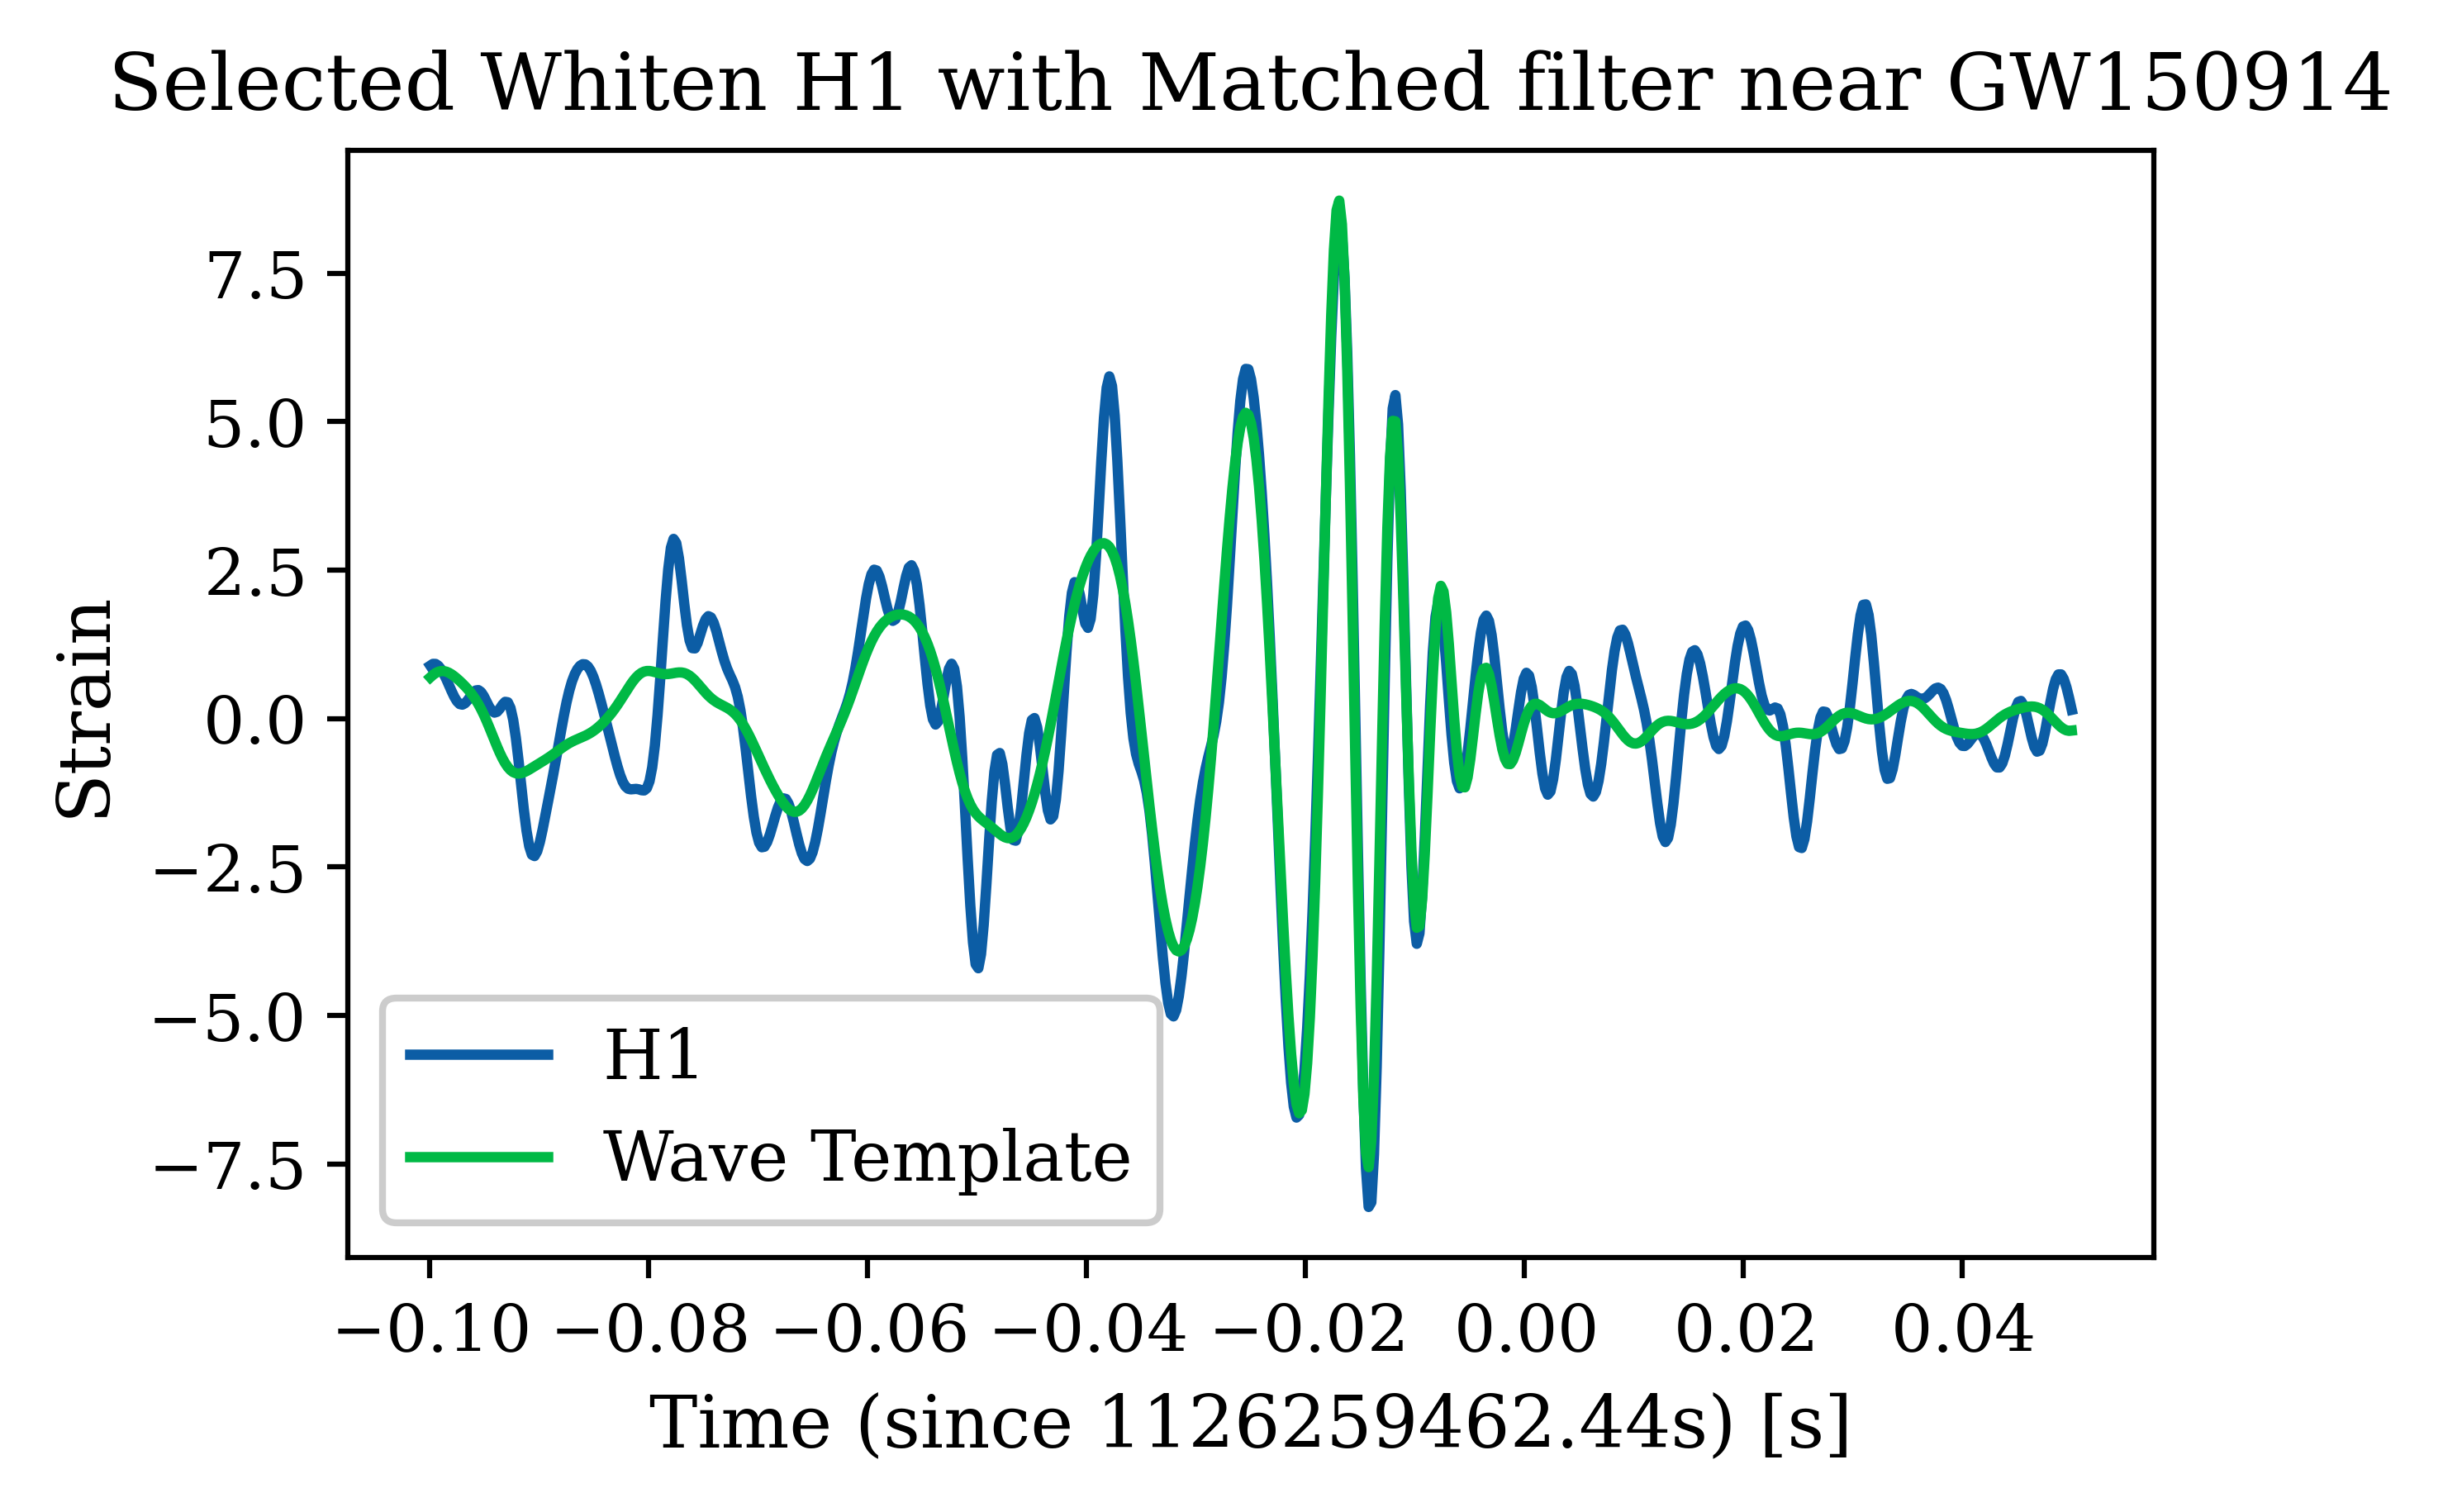

In [66]:
# 处理波形模板
template_phase_shifted = np.real(template*np.exp(1j*phase_H1))
template_rolled = np.roll(template_phase_shifted, offset_H1) / d_eff_H1
whiten_template = ygdu.whiten(template_rolled, psd_H1, f_H1, dt)
selected_whiten_template = ygdu.band_filter(whiten_template, fband, fs)

# 绘图！
with ypu.temp_style(["ysy_academic", "science_color"]):
    ypu.plot(
        time-peak_time_H1, snr_H1, 'H1 SNR(t)', 
        'H1 SNR near GW150914', 'Time (since {0:.4f}s) [s]'.format(peak_time_H1), 'SNR'
    )

    ypu.plot(
        time[indxt2]-t_event, (selected_whiten_H1[indxt2], selected_whiten_template[indxt2]), ('H1', 'Wave Template'), 
        'Selected Whiten H1 with Matched filter near '+event_name, 'Time (since '+str(t_event)+'s) [s]', 'Strain'
    )

In [67]:
# 按同样的流程再处理L1
whiten_L1 = data_GW150914['whiten_L1']
snr_L1, phase_L1, offset_L1, d_eff_L1 = calculate_snr_from_whitened(
    whiten_L1, 
    whiten_ft_template_L1, 
    fs, 
    dt
)

# --- 寻找并输出峰值结果 ---
peak_snr_L1 = np.max(snr_L1)
peak_index_L1 = np.argmax(snr_L1)
peak_time_L1 = time_H1[peak_index_L1]
print("We find max SNR", peak_snr_L1, 'at', peak_time_L1, 's with the effctive distance', d_eff_L1, '.')

We find max SNR 13.11789201519333 at 1126259462.432373 s with the effctive distance 1007.1741110548946 .


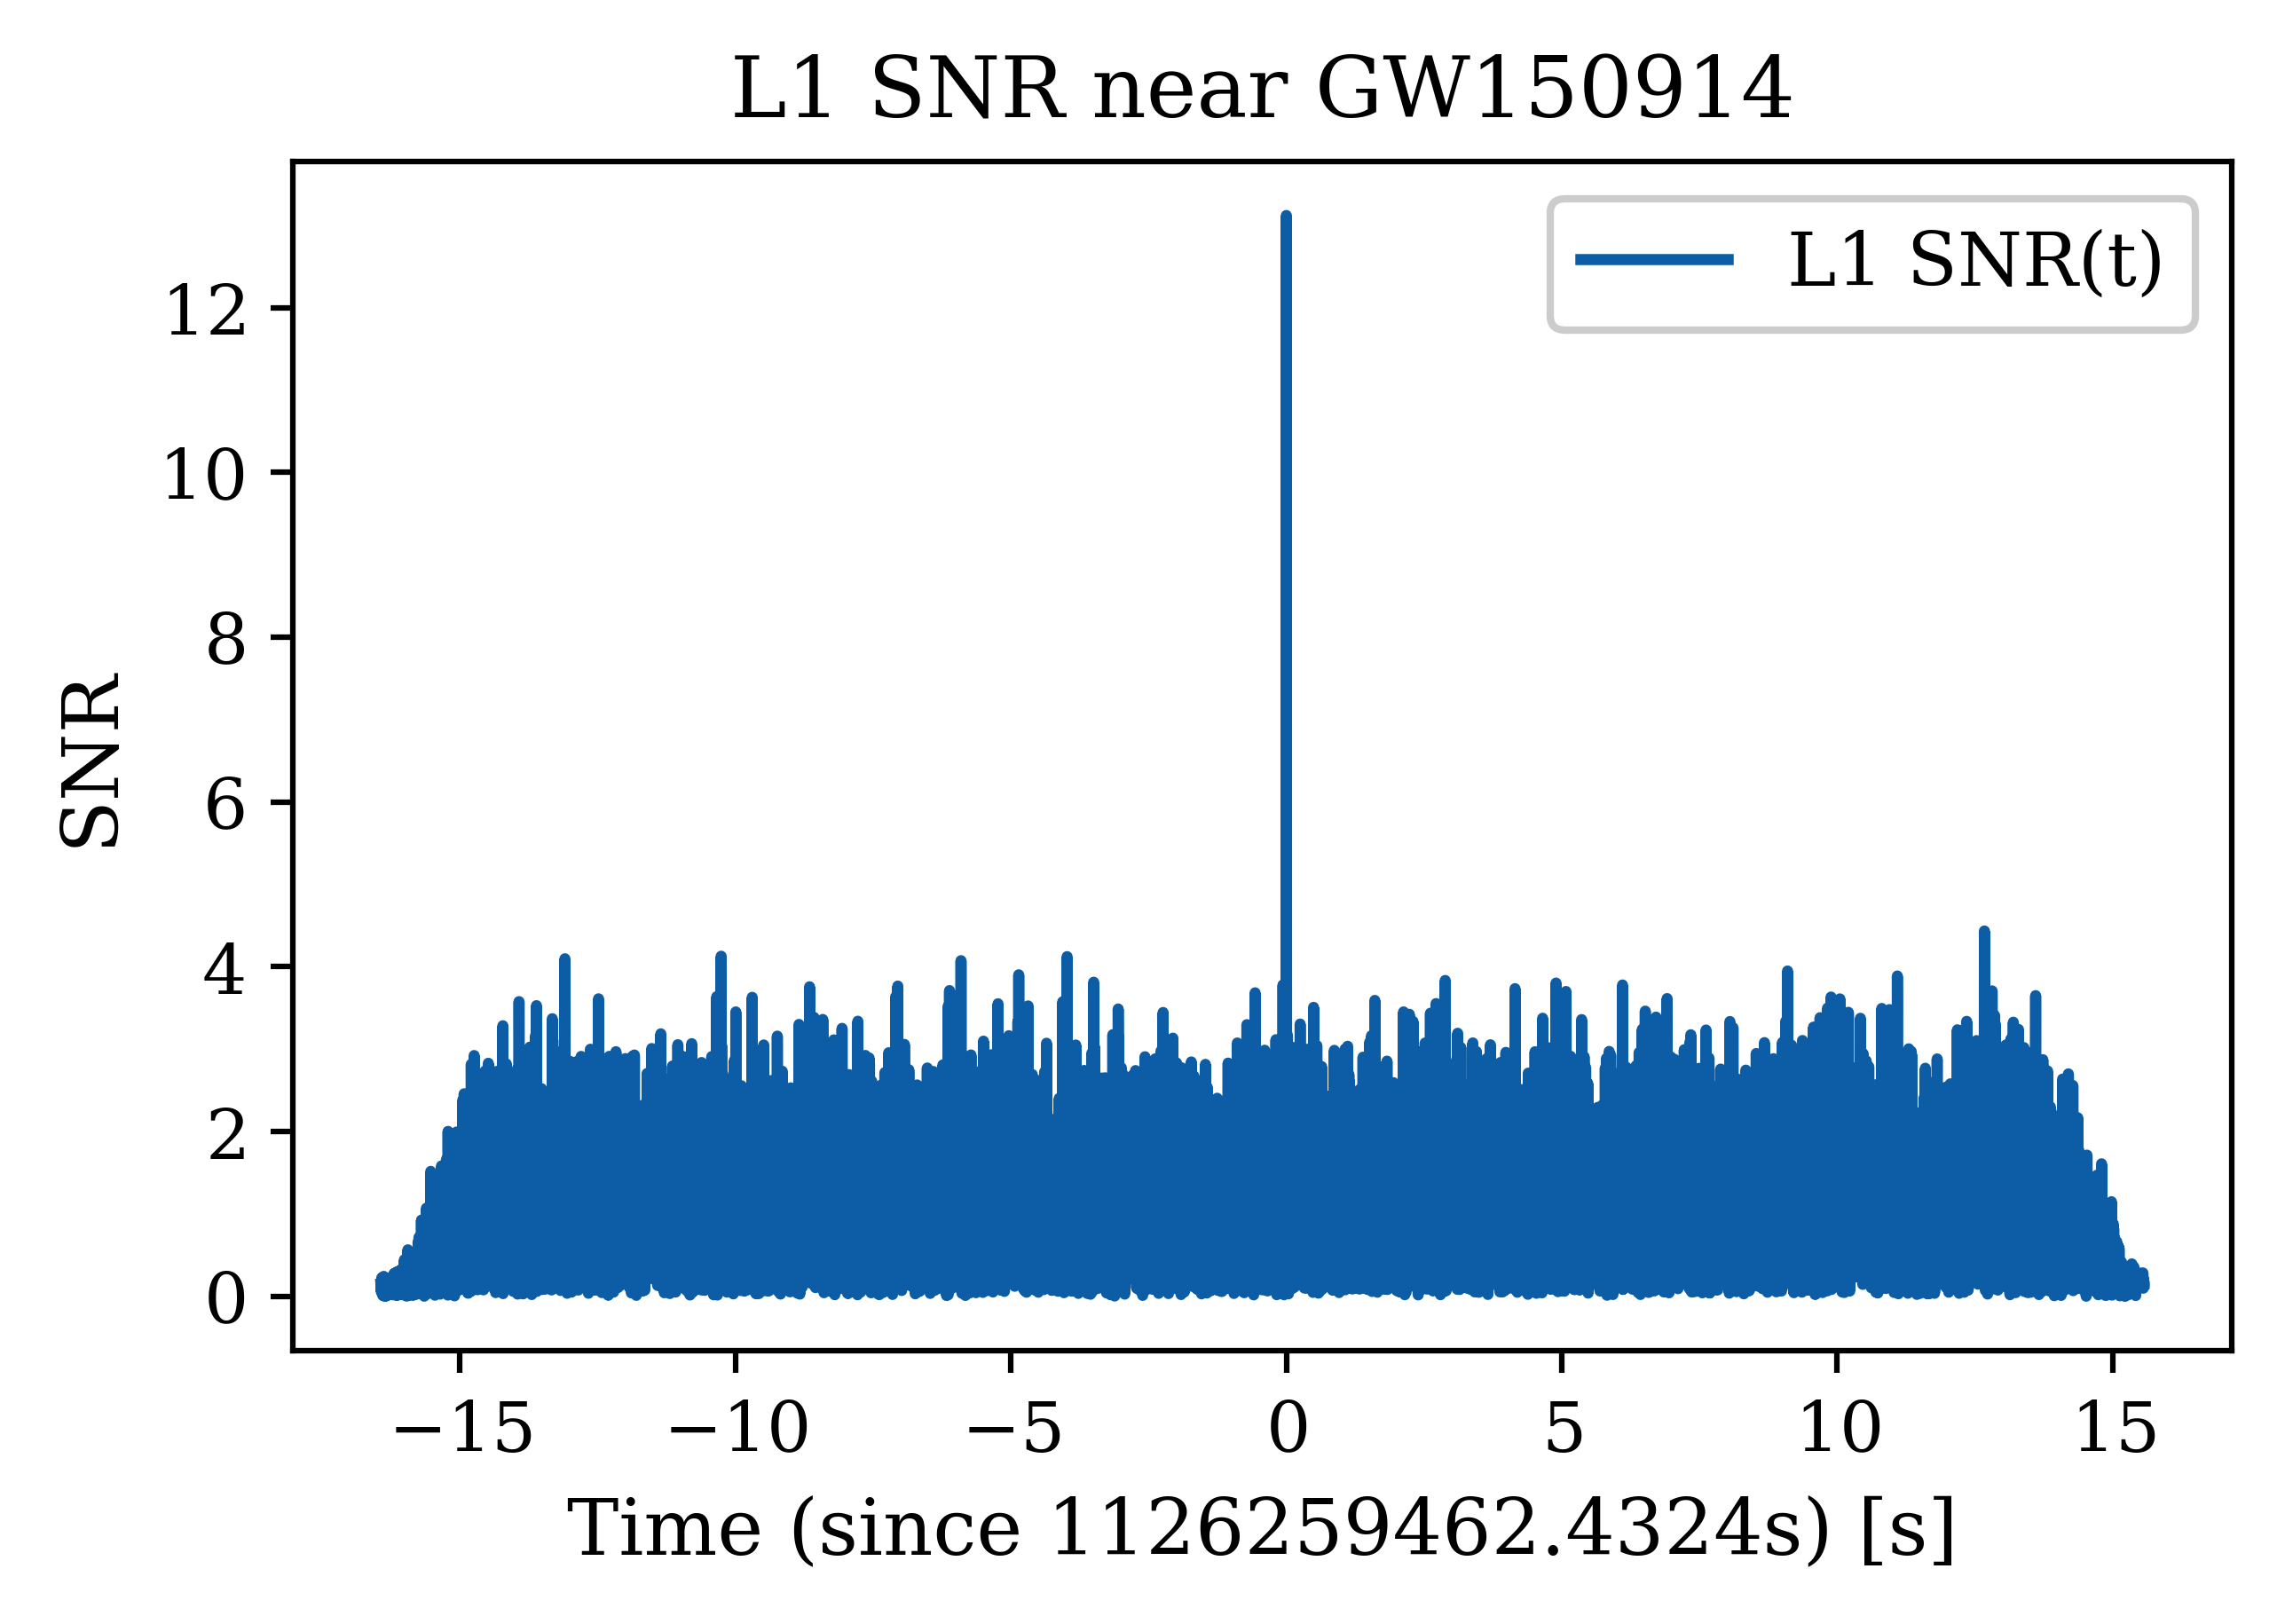

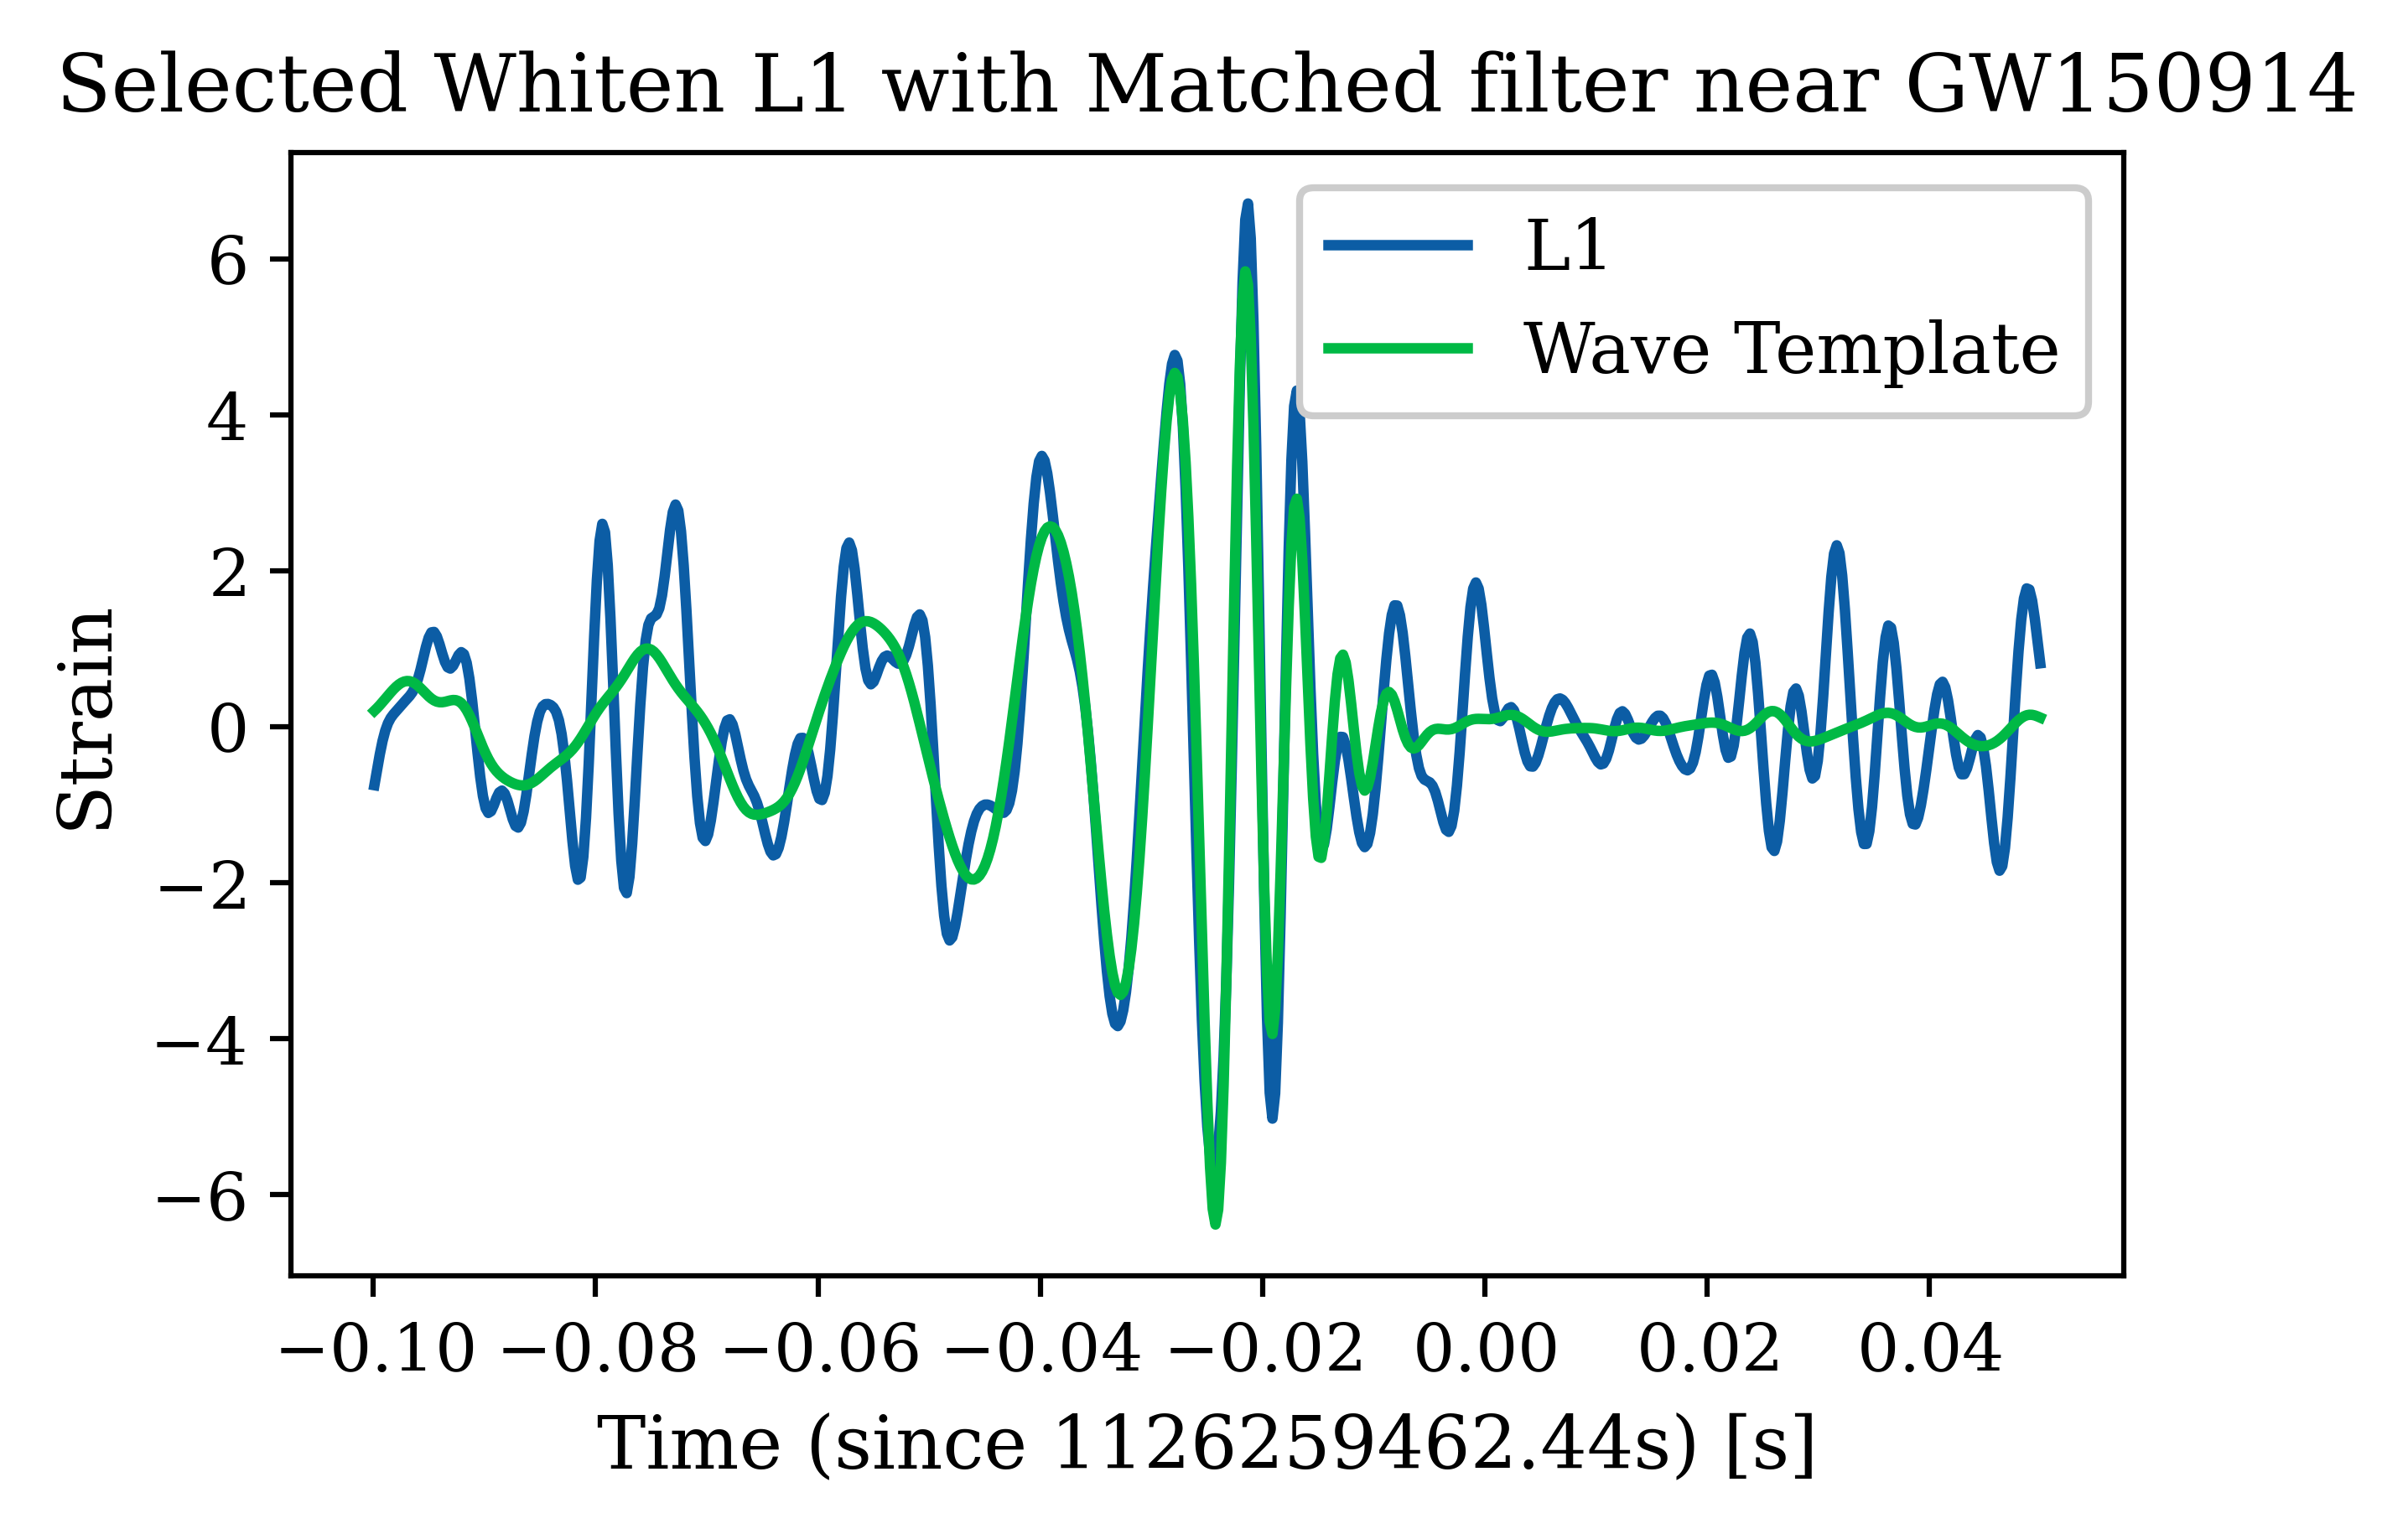

In [68]:
# 处理波形模板
template_phase_shifted = np.real(template*np.exp(1j*phase_L1))
template_rolled = np.roll(template_phase_shifted, offset_L1) / d_eff_L1
whiten_template = ygdu.whiten(template_rolled, psd_L1, f_L1, dt)
selected_whiten_template = ygdu.band_filter(whiten_template, fband, fs)

# 绘图！
with ypu.temp_style(["ysy_academic", "science_color"]):
    ypu.plot(
        time-peak_time_L1, snr_L1, 'L1 SNR(t)', 
        'L1 SNR near GW150914', 'Time (since {0:.4f}s) [s]'.format(peak_time_L1), 'SNR'
    )

    ypu.plot(
        time[indxt2]-t_event, (selected_whiten_L1[indxt2], selected_whiten_template[indxt2]), ('L1', 'Wave Template'), 
        'Selected Whiten L1 with Matched filter near '+event_name, 'Time (since '+str(t_event)+'s) [s]', 'Strain'
    )

## 6 时频图

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ysy_plot_utils as ypu
import ysy_gw_data_utils as ygdu
from gwpy.timeseries import TimeSeries

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [59]:
H1 = TimeSeries.read(
    'H-H1_LOSC_4_V2-1126259446-32.hdf5', 
    format='hdf5.gwosc'
)
qspecgram = H1.q_transform(outseg=(1126259462.2, 1126259462.5))

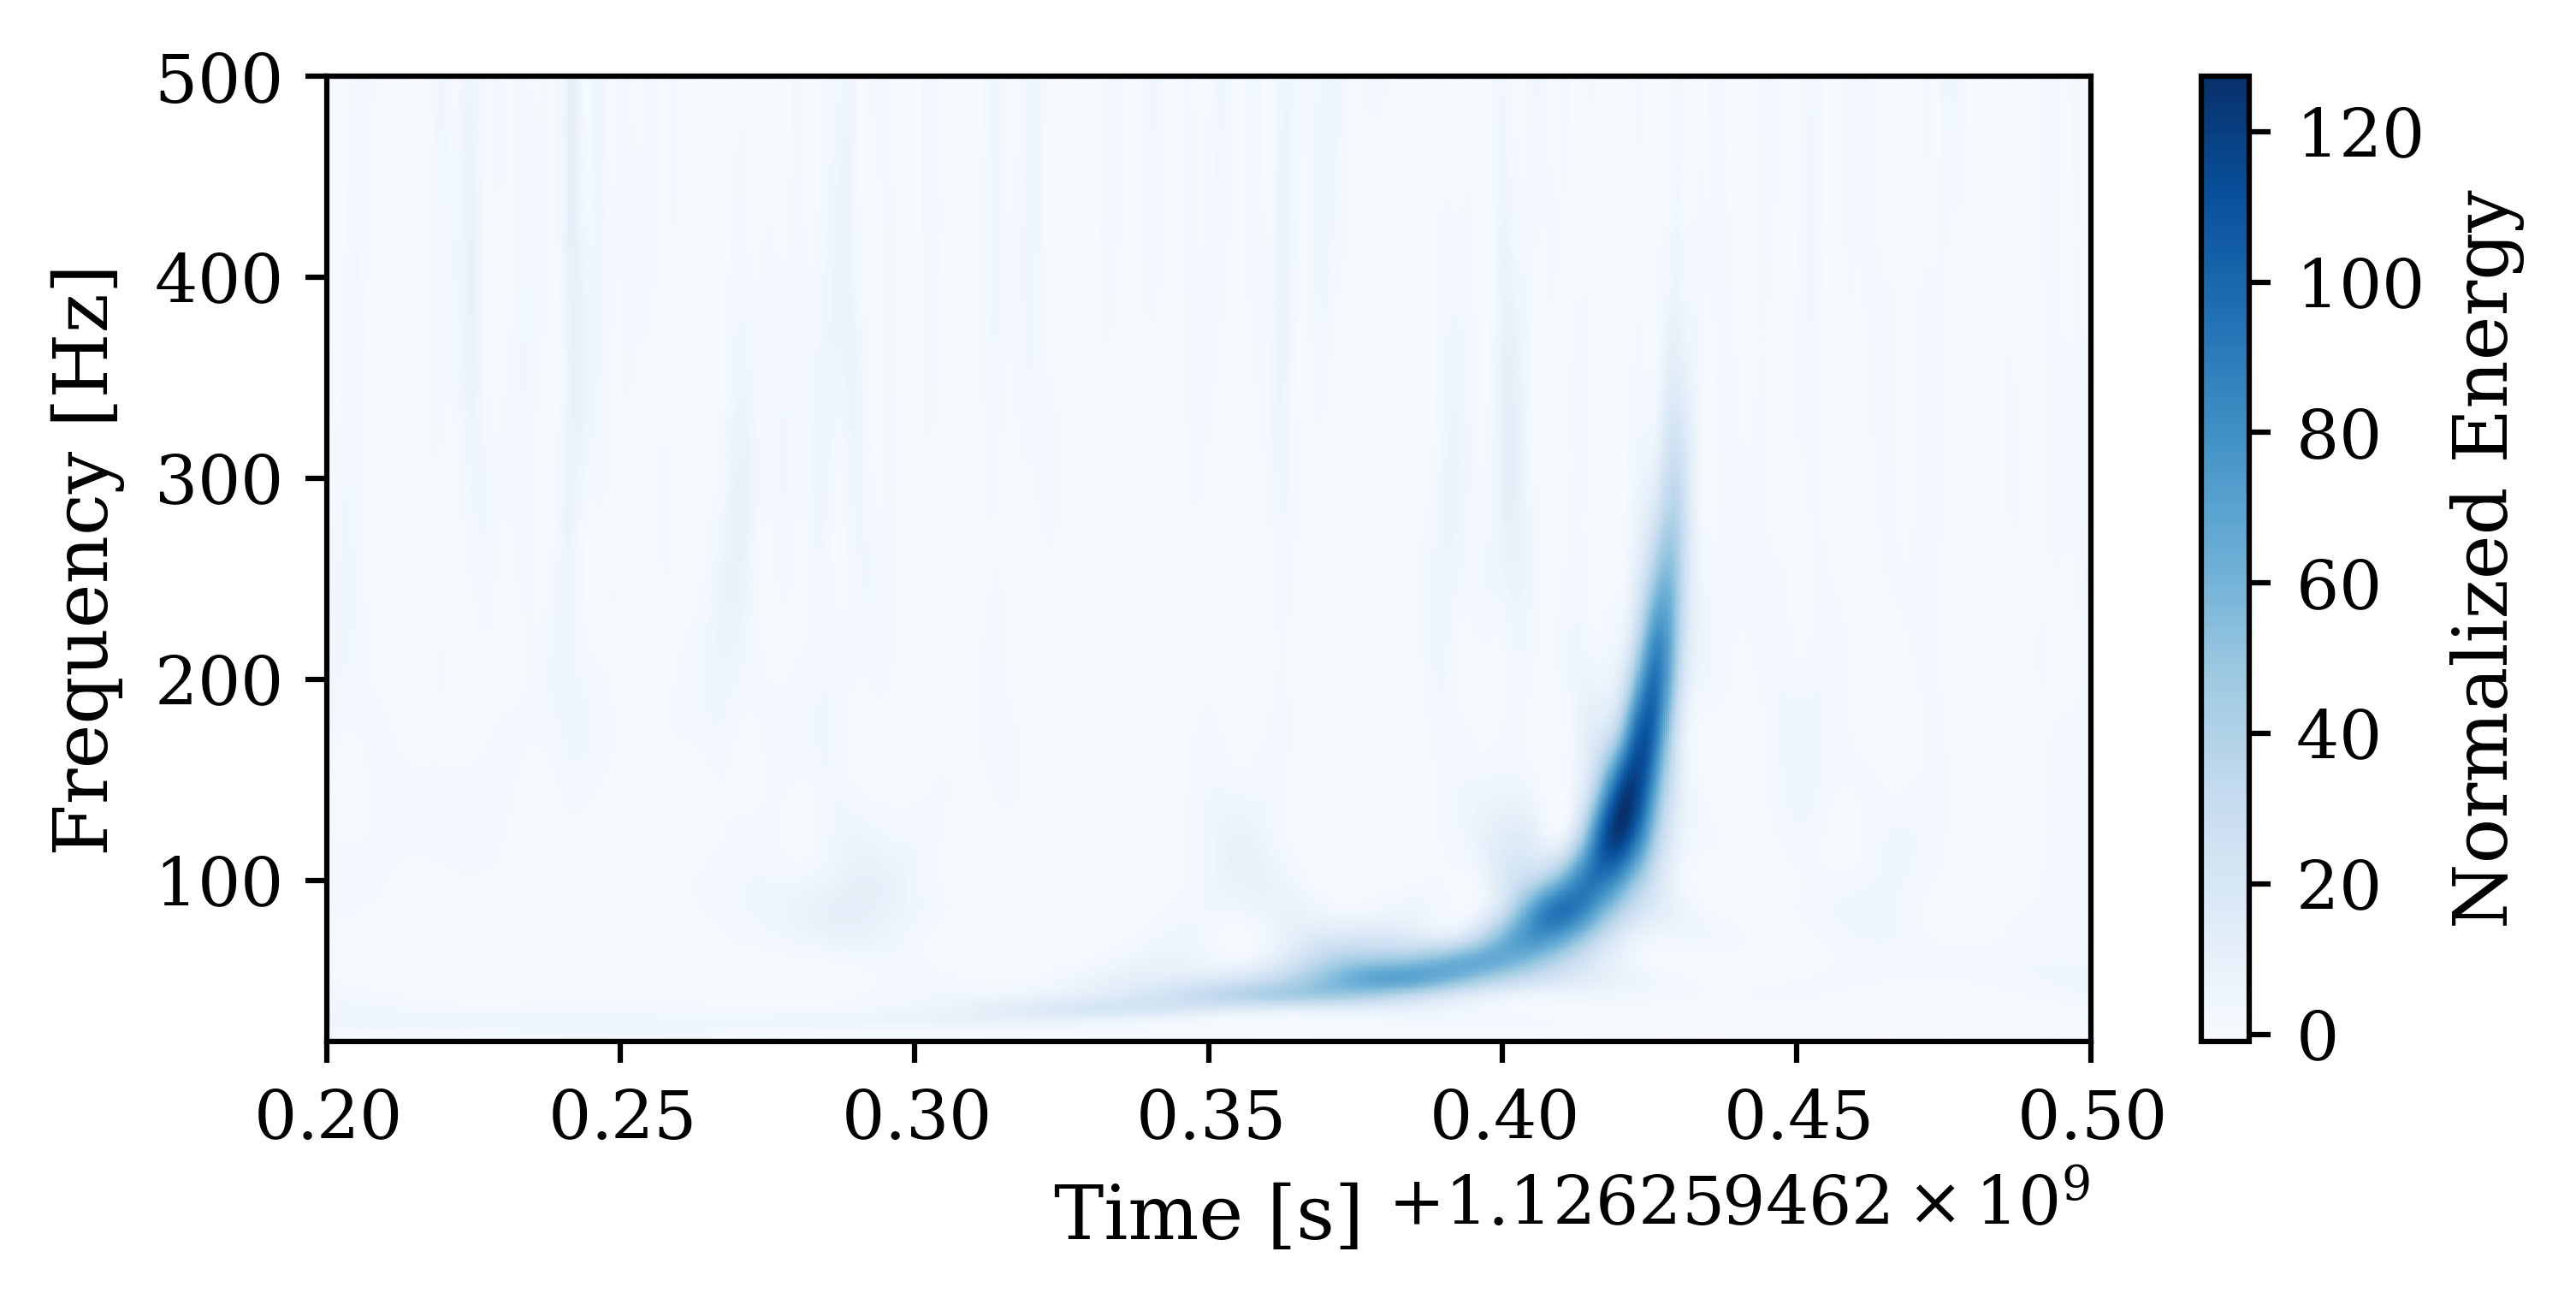

In [62]:
with ypu.temp_style(["ysy_academic", "science_color"]):
    plt.figure(figsize=(4.7*1.1, 2.9/1.1))
    plt.pcolormesh(qspecgram, cmap='Blues')
    plt.colorbar(label='Normalized Energy')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.ylim(20, 500)
    plt.tight_layout()
    plt.show()